# Generate Adversarial Examples with Generative Adversarial Networks
While researchers achieved great success in computer vision tasks using CNNs, it’s a known fact that many machine learning algorithms, e.g. CNNs, fully-connected networks, SVMs, etc., are easily fooled[1, 2, 3]. By adding carefully constructed perturbations to input images, one can mislead known models or even unknown models into classifying input into desired classes. Those carefully designed examples are also known as the adversarial examples. Adversarial perturbations are pretty much imperceptible to human eyes, while those perturbations lead models into misclassification. **In this project, we utilize conditional GANs to generate adversarial examples, which is inspired by [4, 5, 6]**, evaluate the generated examples against some models, and compare this method with other commonly used methods, e.g. Fast Gradient Sign Method(FGSM)[2], and Projected Gradient Descent(PGD)[3].

[[1](https://arxiv.org/abs/1312.6199)] Intriguing properties of neural networks, Christian Szegedy


[[2](https://arxiv.org/abs/1412.6572)] Explaining and harnessing adversarial examples, Ian Goodfellow


[[3](https://arxiv.org/abs/1511.07528)] The Limitations of Deep Learning in Adversarial Settings, Nicolas Papernot


[[4](https://arxiv.org/abs/1706.06083)] Towards Deep Learning Models Resistant to Adversarial Attacks, Aleksander Mądry 


[[5](https://arxiv.org/abs/1801.02610)] Generating Adversarial Examples with Adversarial Networks, Chaowei Xiao


[[6](https://arxiv.org/abs/1903.07282)] Generating Adversarial Examples With Conditional Generative Adversarial Net, Ping Yu


[[7](https://arxiv.org/abs/1908.00706)] AdvGAN++ : Harnessing latent layers for adversary generation, Puneet Mangla



In [52]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utils
import models
import MNIST_model

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

cuda = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Background
### GANs
Generative Adversarial Networks have been used in many applications, like image generation, super resolution, and style transfer. The concept of GAN is about a two-player game, in which there are discriminator and generator. The discriminator tries to distinguish between real data and fake data generated by the generator, and the generator tries to generate data that fools the discriminator.  The two players are competing in a sense, but the discriminator is also teaching the generator how to generate indistinguishable data. The original loss functions for discriminator and generator are:


$${L}_{D}=-\mathbb{E}_{x \sim p_{data}}[logD({x})] - \mathbb{E}_{z \sim p_{z}}[log(1-D(G({z})))],$$


$${L}_{G}=\mathbb{E}_{z \sim p_{z}}[log(1-D(G({z}))].$$


### GAN Loss
While GANs achieve great results in many applications, GANs is also known for its instability of training process. Therefore, besides the original GAN objective function proposed in [8], there are many variants of GAN loss proposed to stabilize the training process. We also experiment with the hinge version of GAN loss.
### Discriminator Loss
Maximize real logtis and to minimize fake logits.


$${L}_{D}=-\mathbb{E}_{(x,y) \sim p_{data}}[min(0, -1+{D}({x, y}))]-\mathbb{E}_{z \sim p_{z},y \sim p_{data}}[min(0,-1-{D(G(z),y)})]$$


### Generator Loss
Maximize fake logits.


$${L}_{G}=-\mathbb{E}_{z \sim p_{z},y \sim p_{data}}{D(G(z),y)}$$


### Adversarial Examples
Adversarial examples are described as input images which are applied imperceptible non-random perturbations which change a classifier's prediction in [1]. $x$ is a clean example, $p$ is the perturbation. $f$ is a classifier, and $t$ is a target label. Perturbation is formal defined as:


$$\mathop{\arg\min}_{p}||p||_{2}, \textrm{ subject to }f(x+p)=t.$$


However, solving this problem directly is hard, so we simplify the adversarial examples as those input images that are classified as original classes by humans and are misclassified as target classes by a ML classifier in this project.


There are many methods proposed to generate adversarial examples. Fast Gradient Sign Method(FGSM) proposed in [2] constructs an adversarial example using the sign of the gradient of the target classifier. FGSM is useful for white-box attacks in general, but it may not be suitable for black-box attacks.


[[8](https://arxiv.org/abs/1406.2661)] Generative Adversarial Networks, Ian J. Goodfellow



# Load MNIST dataset (and train a GAN)
<p>MNIST dataset consists of handwritten digits ranging from 0 to 9 with 60,000 training samples and 10,000 test samples. Because the number of pixels of every sample of MNIST dataset is samll, the adversarial perturbations are somewhat more noticeable than those for ImageNet dataset or even CIFAR dataset.</p>

In [68]:
batch_size = 128
num_classes = 10
out_channels = 1
in_channels = 1
image_size = 28
NUM_TRAIN = 60000
NUM_TEST = 10000
# To ultize GPU, change data type to cuda type
dtype = torch.cuda.FloatTensor

# Load MNIST dataset

mnist_train = dset.MNIST('./datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True)

loader_16 = DataLoader(mnist_train, batch_size=16, shuffle=True)

mnist_test = dset.MNIST('./datasets/MNIST_data', train=False, download=True,
                           transform=T.ToTensor())
loader_test = DataLoader(mnist_test, batch_size=batch_size,
                        shuffle=False)

# White-box attack against an MNIST model with GAN joint trained with GAN loss and adversarial loss
In white-box scenario, an adversary has full access to the target model, including architecture, gradient, parameters, etc. We first experiment with white-box attack, because white-box attack is the most basic form of attacks. While in real-world situation it's not exactly possible an adversary would have that much information, we think it's a great way to get started. Also, due to the transferability of adversarial examples, it's likely that adversarial examples we develop using a specific model are also adversarial examples to other models trained to solve the same task.


Generating adversarial examples with GANs is proposed in [4, 5, 6]. We adapt the advGAN architecture [4] in this project, however

### MNIST model
The MNIST model we use consists of two conv-layers, a fully connected layer, and an output layer which is also a fully connected layer.


 * Convolutional layer with 32 filters, 5x5, stride 1, padding 2 -> maxpool, 2x2, stride 2 -> ReLU
 * Convolutional layer with 64 filters, 5x5, stride 1, padding 2 -> maxpool, 2x2, stride 2 -> ReLU
 * Fully connected layer (64 x 7 x 7)x1024 -> ReLU
 * Fully connected layer 1024x10

### GAN architecture
The GAN architecture we use is similar to pix2pix, and CycleGAN models [10, 11], as described in [4]. The generator takes in input images and output perturbations, and the discriminator takes in clean images and perturbed images generated by the generator and tries to distinguish those images being real or fake. However, there are some changes in both generator and discriminator. In this setup, we don't have ground truth output images and we also incorporate class information in both generator and discriminator. We incorporate class information via class conditional batch normalization in generator and projection in discriminator, as proposed in [9]. We also use spectral normalization which normalizes the weights of each layer to stabilize training process.



We now describe the generation process in detail. The generator takes MNIST images as input and target class information is incorporated into the process through class conditional batch normalization. The target class labels are randomly selected which are different from true class labels. It then outputs perturbations corresponding to the mapping between input class and desired target class. We add the perturbations and the input images to obtain the adversarial examples. During training, we give discriminator {adversarial examples, true labels} and {clean examples, true labels} pairs, because we want to encourage the adversarial examples to look like the original class. We train the GAN with three losses: GAN loss, adversarial loss, and perturbation loss [4]. GAN loss enforces the adversarial examples to look like data from MNIST dataset. Adversarial loss corresponds to the classification loss of the target class of the target model. Perturbation loss controls the magnitude of the perturbation. We can control the importance of each objective through additional hyperparameters.



[[9](https://arxiv.org/abs/1805.08318)] Self-Attention Generative Adversarial Networks, Han Zhang


[[10](https://arxiv.org/abs/1611.07004)] Image-to-Image Translation with Conditional Adversarial Networks, Phillip Isola


[[11](https://arxiv.org/abs/1703.10593)] Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, Jun-Yan Zhu

## Three losses
1. GAN loss
$${L}_{D}=-\mathbb{E}_{(x,y) \sim p_{data}}[min(0, -1+{D}({x, y}))]-\mathbb{E}_{(x,y) \sim p_{data}}[min(0,-1-{D(G(x, t),y)})]$$

$${L}_{G}=-\mathbb{E}_{(x,y) \sim p_{data}}{D(G(x, t),y)}$$
2. Adversarial loss  
The equation is the $f_6$ in [12]  
$f$ is the target classifier.
$${L}_{adv}={\max(\mathop{\max}_{i\neq t}(f(x + G(x, t))_{i})-f(x + G(x, t))_{i}, 0)}$$
3. Perturbation loss
$${L}_{per}=\mathbb{E}_{x \sim p_{data}}{max(0, \|G(x, t)\|_{2}-\epsilon)}$$

## Full loss 
### Discriminator
$${L}_{D}=-\mathbb{E}_{(x,y) \sim p_{data}}[min(0, -1+{D}({x, y}))]-\mathbb{E}_{(x,y) \sim p_{data}}[min(0,-1-{D(G(x, t),y)})]$$
### Generator
$${L}={L}_{G}+\alpha{L}_{adv}+\beta{L}_{per}$$

[[12](https://arxiv.org/abs/1608.04644)] Towards Evaluating the Robustness of Neural Networks, Nicholas Carlini

# Train a MNIST model, the target model
<p>We train a convolutional network with three hidden layers, which is as described in [4]. We use Adam optimizer to train the model with xaiver initialization and train it for 10 epochs over the entire MINST training set and the model achieves ~98% test accuracy.</p>

In [75]:
def solver(model, optim, loss_fn, batch_size, num_epochs):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, y in loader_train:
            x = x.cuda()
            y = y.cuda()
            optim.zero_grad()
            scores = model(x)
            model.train()
            loss = loss_fn(scores, y)
            loss.backward()
            optim.step()
            if(iter_count % 250  == 0):
                print("loss: {0:.6f}".format(loss))
                check_accuracy(model, loader_train, 1000)
            iter_count += 1
            
def check_accuracy(model, loader, samples=None, batch_size=128):
    if loader.dataset.train:
        print('Checking accuracy on training set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    num_batches = None
    batch_count = 0
    if samples is not None:
        num_batches = samples // batch_size + 1
    for x, y in loader:
        x = x.type(dtype)
        if samples is not None:
            if batch_count > num_batches:
                break
            batch_count += 1
        scores = model(x)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [76]:
initialization = functools.partial(utils.initialize_weights)
model = MNIST_model.model().type(dtype)
model.apply(initialization)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.9), eps=1e-08, weight_decay=0, amsgrad=False)
loss_fn = nn.CrossEntropyLoss()
solver(model, optim, loss_fn, batch_size, num_classes)
model.eval()
check_accuracy(model, loader_test)
torch.save(model.state_dict(), 'MNIST_weights')

loss: 2.330725
Checking accuracy on training set
Got 114 / 1152 correct (9.90)
loss: 0.083928
Checking accuracy on training set
Got 1130 / 1152 correct (98.09)
loss: 0.008413
Checking accuracy on training set
Got 1130 / 1152 correct (98.09)
loss: 0.009610
Checking accuracy on training set
Got 1140 / 1152 correct (98.96)
loss: 0.026399
Checking accuracy on training set
Got 1145 / 1152 correct (99.39)
loss: 0.003649
Checking accuracy on training set
Got 1144 / 1152 correct (99.31)
loss: 0.003924
Checking accuracy on training set
Got 1146 / 1152 correct (99.48)
loss: 0.003527
Checking accuracy on training set
Got 1149 / 1152 correct (99.74)
loss: 0.005727
Checking accuracy on training set
Got 1148 / 1152 correct (99.65)
loss: 0.010307
Checking accuracy on training set
Got 1149 / 1152 correct (99.74)
loss: 0.065632
Checking accuracy on training set
Got 1149 / 1152 correct (99.74)
loss: 0.000023
Checking accuracy on training set
Got 1148 / 1152 correct (99.65)
loss: 0.004562
Checking accura

In [127]:
def run_a_gan_modified(D, G, D_solver, G_solver, discriminator_loss, generator_loss, model, eps, alpha, beta,
                       show_every=250, batch_size=128, num_epochs=10, lr_scheduler='linear'):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - model: Targeted model
    - loss_fn: Loss function used to train the targeted model - deprecated
    - eps: eps determines the perturbation margin.
    - alpha: Weight of adversarial loss
    - beta: Weight of perturbation loss
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - lr_scheduler: learning rate scheduler
    """
    iter_count = 0
    adv_loss_record = []
    success_record = []
    if lr_scheduler == 'step':
        D_scheduler = torch.optim.lr_scheduler.StepLR(D_solver, step_size=5, gamma=0.1)
        G_scheduler = torch.optim.lr_scheduler.StepLR(G_solver, step_size=5, gamma=0.1)
    elif lr_scheduler == 'plateau':
        D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(D_solver, patience=5, threshold=0.01)
        G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(G_solver, patience=5, threshold=0.01)
    for epoch in range(num_epochs):
        success = 0
        examples = 0 
        for x, y in loader_train:
            if len(x) != batch_size:
                continue
            L_inf = 0.3
            real_data = x.type(dtype)
            real_labels = y.type(torch.cuda.LongTensor)
            
            D_solver.zero_grad()
            # make target labels which are different from ground truth labels
            rand_shift = torch.randint(low=1, high=10, size=(batch_size, 1), device=cuda).squeeze()
            target_labels = ((real_labels + rand_shift) % 10)          
            # for discriminator that uses projection
            logits_real = D(real_data, real_labels)
            
            perturbation = torch.clamp(G(real_data, target_labels).detach(), -L_inf, L_inf)
            fake_imgs = torch.clamp(perturbation + real_data, 0.0, 1.0)
            # for discriminator that uses projection
            logits_fake = D(fake_imgs, real_labels)

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            perturbation = torch.clamp(G(real_data, target_labels), -L_inf, L_inf)
            fake_imgs = torch.clamp(perturbation + real_data, 0.0, 1.0)
            # for discriminator that uses projection
            gen_logits_fake = D(fake_imgs, real_labels)
            gan_loss = generator_loss(gen_logits_fake)
            adv_loss = utils.adversarial_loss(model, fake_imgs, target_labels, k=20)
            per_loss = utils.perturbation_loss(perturbation, eps)
            g_error = gan_loss + alpha * adv_loss + beta * per_loss
            adv_loss_record.append(float(adv_loss))
            
            g_error.backward()
            G_solver.step()
            
            pred = model(fake_imgs).argmax(dim=1)
            success += (pred == target_labels).sum()
            examples += len(y)
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G: {:.4}, Adv: {:.4}, Per: {:.4}'.format(iter_count,d_total_error.item(),
                                                                                    gan_loss.item(), adv_loss.item(), 
                                                                                    per_loss.item()))
                print("Prediction: {}".format(pred[0:16].tolist()))
                print("Target:     {}".format(target_labels[0:16].tolist()))
                imgs_numpy = (fake_imgs).data.cpu().numpy()
                utils.show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1
        success_rate = float(success) / examples
        success_record.append(success_rate)
        print('{} epoch, attack success rate: {:.4}%\n'.format(epoch + 1, success_rate * 100))
        
        if lr_scheduler == 'step':
            D_scheduler.step()
            G_scheduler.step()
        elif lr_scheduler == 'plateau':
            D_scheduler.step(d_total_error)
            G_scheduler.step(adv_loss)
    return adv_loss_record, success_record

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iter: 0, D: 1.981, G: 0.4405, Adv: 7.203, Per: 7.347
Prediction: [8, 3, 3, 7, 9, 3, 8, 2, 3, 2, 3, 2, 3, 6, 9, 3]
Target:     [7, 3, 7, 0, 7, 9, 5, 6, 3, 0, 5, 8, 0, 3, 8, 4]


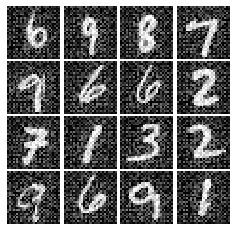

KeyboardInterrupt: 

In [94]:
model = MNIST_model.model().type(dtype)
model.load_state_dict(torch.load('MNIST_weights'))

initialization_d = functools.partial(utils.initialize_weights, method='He', act='leaky_relu')
initialization_g = functools.partial(utils.initialize_weights, method='He')
adv_d_p = models.Discriminator().type(dtype)
adv_d_p.apply(initialization_d)
adv_g_u = models.Generator(norm='instance').type(dtype)
adv_g_u.apply(initialization_g)

adv_d_p_optimizer = torch.optim.Adam(adv_d_p.parameters(), lr=4e-4, betas=(0, 0.9))
adv_g_u_optimizer = torch.optim.Adam(adv_g_u.parameters(), lr=1e-4, betas=(0, 0.9))

loss_ins, success_record_ins = run_a_gan_modified(adv_d_p, adv_g_u, adv_d_p_optimizer, adv_g_u_optimizer, utils.discriminator_loss, 
                                                  utils.generator_loss, model, 0, 10, 5, num_epochs=50, batch_size=batch_size, lr_scheduler='linear')

Iter: 0, D: 1.995, G: 0.1878, Adv: 27.4, Per: 5.238
Prediction: [0, 3, 8, 5, 5, 5, 5, 9, 1, 6, 6, 7, 3, 5, 0, 3]
Target:     [1, 7, 7, 0, 8, 0, 8, 7, 5, 8, 3, 3, 4, 8, 2, 5]


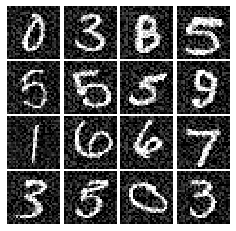


Iter: 250, D: 0.001273, G: 1.537, Adv: 1.642, Per: 3.652
Prediction: [7, 5, 8, 0, 3, 7, 4, 4, 4, 1, 3, 1, 8, 3, 9, 8]
Target:     [2, 0, 7, 3, 2, 6, 3, 8, 2, 3, 2, 0, 8, 9, 9, 0]


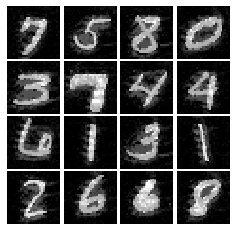


1 epoch, attack success rate: 3.486%

Iter: 500, D: 7.766e-05, G: 1.611, Adv: 1.431, Per: 3.564
Prediction: [4, 3, 6, 1, 6, 0, 2, 9, 3, 1, 2, 3, 2, 9, 9, 8]
Target:     [7, 1, 3, 3, 5, 4, 9, 8, 4, 7, 1, 6, 0, 6, 2, 6]


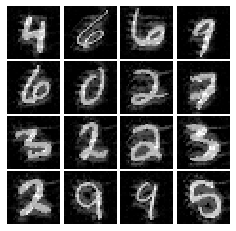


Iter: 750, D: 1.686e-06, G: 1.694, Adv: 1.716, Per: 3.483
Prediction: [5, 2, 3, 1, 5, 8, 2, 1, 3, 1, 6, 2, 8, 0, 0, 8]
Target:     [1, 5, 9, 9, 7, 5, 9, 8, 5, 6, 3, 4, 6, 5, 3, 6]


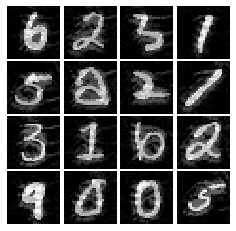


2 epoch, attack success rate: 5.604%

Iter: 1000, D: 1.12e-05, G: 1.685, Adv: 1.285, Per: 3.478
Prediction: [6, 9, 8, 3, 8, 3, 1, 4, 5, 2, 4, 8, 8, 8, 9, 7]
Target:     [7, 9, 0, 5, 9, 1, 5, 2, 7, 0, 9, 9, 3, 1, 4, 1]


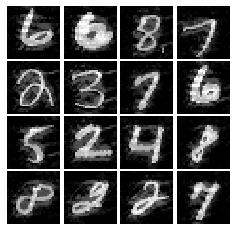


Iter: 1250, D: 0.0003744, G: 1.833, Adv: 0.7738, Per: 3.502
Prediction: [9, 9, 3, 1, 2, 1, 2, 7, 2, 2, 9, 2, 7, 9, 3, 5]
Target:     [1, 9, 1, 8, 2, 6, 2, 5, 2, 2, 9, 2, 7, 3, 3, 6]


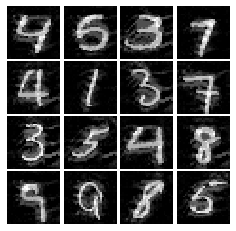


3 epoch, attack success rate: 20.39%

Iter: 1500, D: 0.0, G: 1.778, Adv: 0.056, Per: 3.547
Prediction: [8, 3, 5, 8, 9, 1, 6, 1, 5, 7, 3, 5, 2, 1, 7, 7]
Target:     [6, 3, 5, 0, 9, 4, 5, 0, 5, 4, 0, 5, 2, 4, 7, 5]


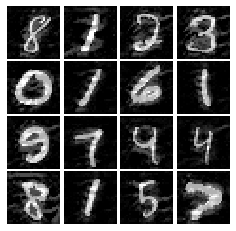


Iter: 1750, D: 2.491e-05, G: 1.962, Adv: -1.038, Per: 3.906
Prediction: [1, 5, 3, 2, 3, 4, 3, 8, 7, 7, 7, 8, 6, 8, 2, 9]
Target:     [1, 5, 3, 2, 3, 4, 0, 8, 7, 7, 1, 8, 6, 8, 2, 4]


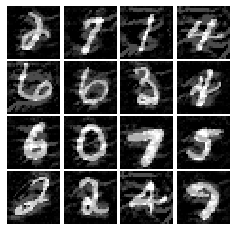


4 epoch, attack success rate: 53.13%

Iter: 2000, D: 0.0006346, G: 2.111, Adv: -2.387, Per: 4.067
Prediction: [5, 1, 3, 2, 5, 4, 3, 5, 9, 4, 9, 9, 9, 0, 8, 3]
Target:     [5, 9, 3, 0, 5, 4, 6, 5, 0, 4, 9, 9, 9, 6, 8, 6]


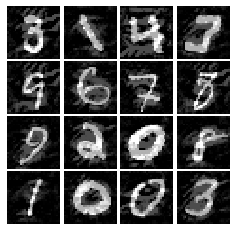


Iter: 2250, D: 9.112e-06, G: 1.87, Adv: -4.162, Per: 4.239
Prediction: [9, 8, 9, 2, 1, 9, 7, 3, 5, 5, 3, 4, 7, 9, 5, 8]
Target:     [9, 8, 9, 0, 1, 9, 7, 0, 5, 5, 0, 4, 7, 9, 5, 8]


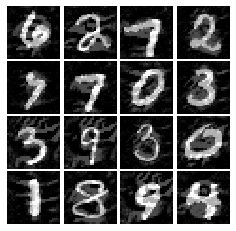


5 epoch, attack success rate: 72.08%

Iter: 2500, D: 6.065e-05, G: 1.955, Adv: -4.531, Per: 4.386
Prediction: [3, 4, 7, 5, 8, 3, 7, 3, 4, 3, 2, 8, 4, 2, 1, 9]
Target:     [6, 4, 7, 5, 8, 3, 1, 3, 4, 3, 6, 8, 1, 2, 0, 9]


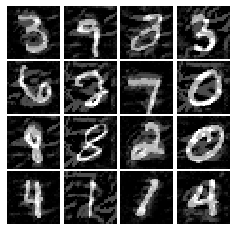


Iter: 2750, D: 0.01724, G: 1.253, Adv: -5.0, Per: 4.387
Prediction: [6, 7, 5, 9, 9, 9, 5, 8, 8, 2, 1, 2, 7, 4, 7, 2]
Target:     [6, 7, 5, 6, 9, 9, 5, 8, 0, 0, 1, 2, 7, 4, 7, 0]


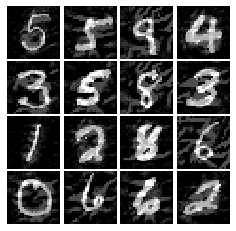


6 epoch, attack success rate: 77.88%

Iter: 3000, D: 2.277e-06, G: 2.064, Adv: -5.619, Per: 4.495
Prediction: [9, 3, 2, 8, 2, 2, 2, 4, 3, 0, 9, 5, 5, 5, 1, 3]
Target:     [9, 0, 2, 0, 2, 1, 2, 4, 3, 6, 9, 5, 5, 5, 1, 3]


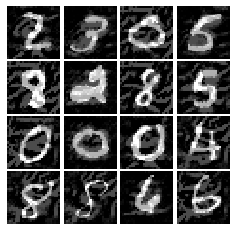


Iter: 3250, D: 0.0, G: 2.083, Adv: -4.784, Per: 4.461
Prediction: [5, 4, 5, 5, 7, 5, 7, 8, 1, 8, 4, 2, 7, 6, 0, 6]
Target:     [5, 4, 1, 5, 7, 5, 7, 0, 1, 0, 4, 2, 7, 6, 0, 6]


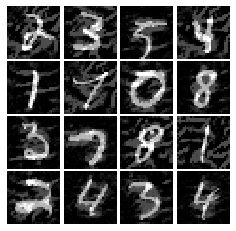


7 epoch, attack success rate: 81.7%

Iter: 3500, D: 3.853e-05, G: 1.998, Adv: -6.184, Per: 4.43
Prediction: [1, 1, 8, 8, 0, 5, 3, 3, 7, 4, 8, 0, 5, 1, 7, 8]
Target:     [6, 1, 8, 8, 0, 5, 3, 6, 7, 4, 8, 0, 5, 1, 1, 8]


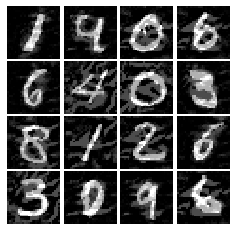


8 epoch, attack success rate: 84.69%

Iter: 3750, D: 0.0, G: 2.07, Adv: -7.048, Per: 4.561
Prediction: [5, 5, 1, 5, 4, 4, 2, 5, 3, 1, 9, 8, 2, 5, 5, 7]
Target:     [6, 5, 1, 5, 4, 4, 2, 5, 3, 1, 9, 8, 2, 5, 5, 7]


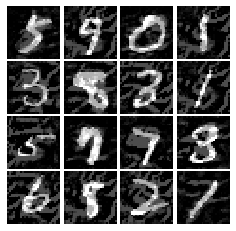


Iter: 4000, D: 0.0, G: 2.153, Adv: -5.886, Per: 4.475
Prediction: [1, 3, 9, 0, 8, 3, 1, 3, 5, 1, 5, 1, 1, 9, 9, 5]
Target:     [1, 3, 9, 0, 8, 3, 0, 0, 5, 1, 1, 1, 0, 9, 9, 5]


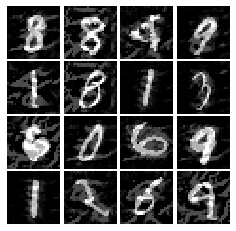


9 epoch, attack success rate: 87.08%

Iter: 4250, D: 0.0, G: 2.136, Adv: -5.53, Per: 4.486
Prediction: [2, 1, 1, 1, 3, 2, 8, 5, 1, 3, 2, 3, 6, 8, 1, 4]
Target:     [2, 6, 1, 1, 3, 2, 8, 5, 1, 3, 2, 3, 6, 8, 1, 4]


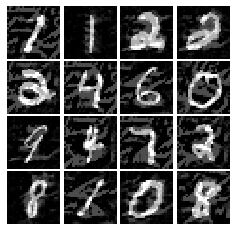


Iter: 4500, D: 0.0, G: 2.234, Adv: -7.452, Per: 4.556
Prediction: [3, 8, 2, 7, 4, 3, 1, 8, 4, 9, 4, 9, 9, 5, 8, 2]
Target:     [3, 6, 2, 7, 4, 3, 1, 0, 1, 9, 4, 9, 9, 5, 8, 2]


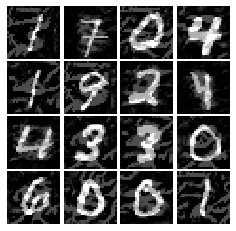


10 epoch, attack success rate: 89.03%

Iter: 4750, D: 0.0, G: 2.075, Adv: -7.504, Per: 4.589
Prediction: [6, 7, 2, 2, 9, 5, 9, 5, 7, 0, 3, 9, 6, 7, 2, 7]
Target:     [6, 7, 2, 2, 9, 5, 9, 5, 7, 0, 3, 9, 6, 6, 2, 7]


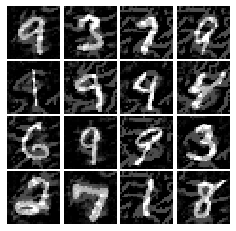


Iter: 5000, D: 0.0, G: 2.016, Adv: -7.537, Per: 4.614
Prediction: [2, 1, 8, 3, 2, 4, 9, 0, 8, 3, 5, 3, 6, 7, 6, 4]
Target:     [2, 0, 8, 3, 2, 4, 9, 0, 8, 3, 5, 3, 6, 7, 0, 4]


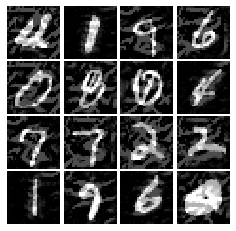


11 epoch, attack success rate: 92.92%

Iter: 5250, D: 1.482e-05, G: 2.358, Adv: -7.786, Per: 4.584
Prediction: [3, 6, 0, 4, 7, 6, 0, 7, 5, 8, 6, 2, 3, 0, 8, 8]
Target:     [3, 6, 0, 4, 7, 6, 0, 7, 5, 8, 6, 2, 3, 0, 8, 8]


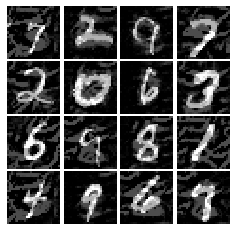


Iter: 5500, D: 0.0, G: 2.279, Adv: -8.237, Per: 4.627
Prediction: [8, 8, 4, 2, 0, 1, 1, 2, 1, 6, 8, 2, 8, 9, 1, 8]
Target:     [8, 8, 4, 2, 0, 1, 1, 0, 1, 6, 8, 2, 8, 9, 0, 8]


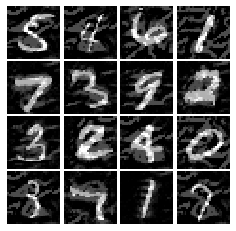


12 epoch, attack success rate: 94.81%

Iter: 5750, D: 0.0, G: 2.316, Adv: -7.409, Per: 4.662
Prediction: [6, 1, 6, 8, 5, 3, 6, 8, 6, 4, 4, 7, 5, 6, 6, 5]
Target:     [0, 1, 6, 8, 5, 3, 6, 8, 6, 4, 4, 7, 5, 6, 6, 5]


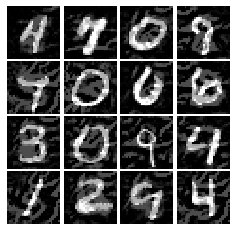


Iter: 6000, D: 0.0, G: 2.132, Adv: -7.57, Per: 4.63
Prediction: [9, 9, 4, 8, 2, 4, 9, 9, 0, 1, 2, 2, 1, 6, 8, 3]
Target:     [9, 9, 4, 8, 2, 4, 9, 9, 0, 1, 2, 2, 1, 6, 0, 3]


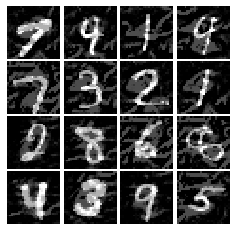


13 epoch, attack success rate: 95.54%

Iter: 6250, D: 0.0, G: 2.29, Adv: -7.544, Per: 4.699
Prediction: [4, 0, 1, 9, 3, 4, 2, 5, 7, 1, 8, 7, 5, 8, 6, 3]
Target:     [4, 0, 1, 9, 3, 4, 2, 5, 7, 1, 0, 7, 5, 8, 6, 3]


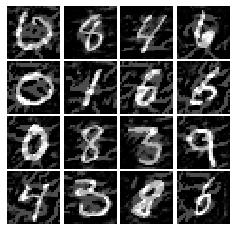


Iter: 6500, D: 1.164e-05, G: 2.373, Adv: -8.664, Per: 4.708
Prediction: [1, 8, 0, 5, 4, 1, 5, 3, 5, 5, 6, 2, 2, 1, 7, 9]
Target:     [1, 8, 0, 5, 4, 1, 5, 3, 5, 5, 6, 2, 2, 1, 7, 9]


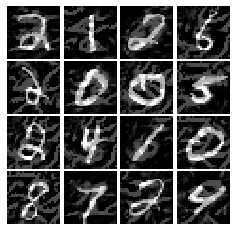


14 epoch, attack success rate: 96.0%

Iter: 6750, D: 0.0, G: 2.393, Adv: -8.86, Per: 4.678
Prediction: [1, 3, 6, 2, 7, 3, 5, 2, 3, 7, 7, 9, 4, 7, 5, 9]
Target:     [1, 3, 6, 2, 7, 3, 5, 2, 3, 7, 7, 9, 4, 7, 5, 9]


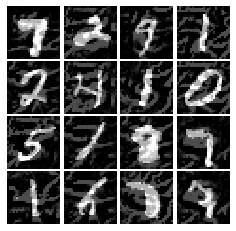


Iter: 7000, D: 0.0, G: 2.493, Adv: -8.082, Per: 4.622
Prediction: [6, 3, 5, 2, 7, 6, 5, 6, 8, 1, 7, 6, 6, 4, 0, 1]
Target:     [6, 3, 5, 2, 7, 6, 5, 6, 8, 1, 7, 6, 6, 4, 0, 1]


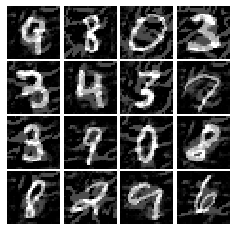


15 epoch, attack success rate: 96.5%

Iter: 7250, D: 0.0, G: 2.452, Adv: -8.881, Per: 4.68
Prediction: [9, 5, 9, 2, 7, 8, 8, 9, 5, 1, 7, 2, 9, 2, 6, 0]
Target:     [9, 5, 9, 2, 7, 8, 8, 9, 5, 1, 7, 2, 9, 2, 6, 0]


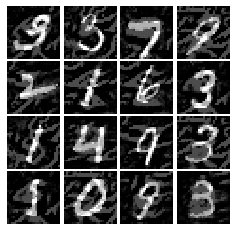

In [ ]:
model = MNIST_model.model().type(dtype)
model.load_state_dict(torch.load('MNIST_weights'))

initialization_d = functools.partial(utils.initialize_weights, method='He', act='leaky_relu')
initialization_g = functools.partial(utils.initialize_weights, method='He')
adv_d_p_b = models.Discriminator().type(dtype)
adv_d_p_b.apply(initialization_d)
adv_g_u_b = models.Generator(use_dropout=True).type(dtype)
adv_g_u_b.apply(initialization_g)

adv_d_p_optimizer = torch.optim.Adam(adv_d_p_b.parameters(), lr=4e-4, betas=(0, 0.9))
adv_g_u_optimizer = torch.optim.Adam(adv_g_u_b.parameters(), lr=1e-4, betas=(0, 0.9))

loss, success_record = run_a_gan_modified(adv_d_p_b, adv_g_u_b, adv_d_p_optimizer, adv_g_u_optimizer, utils.discriminator_loss,
                                          utils.generator_loss, model, 0, 1, 2, num_epochs=20, lr_scheduler='linear')

In [113]:
def run_a_gan_modified(D, G, D_solver, G_solver, discriminator_loss, generator_loss, model, eps, alpha, beta,
                       show_every=250, batch_size=128, num_epochs=10, lr_scheduler='linear'):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - model: Targeted model
    - loss_fn: Loss function used to train the targeted model - deprecated
    - eps: eps determines the perturbation margin.
    - alpha: Weight of adversarial loss
    - beta: Weight of perturbation loss
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - lr_scheduler: learning rate scheduler
    """
    iter_count = 0
    adv_loss_record = []
    success_record = []
    if lr_scheduler == 'step':
        D_scheduler = torch.optim.lr_scheduler.StepLR(D_solver, step_size=5, gamma=0.1)
        G_scheduler = torch.optim.lr_scheduler.StepLR(G_solver, step_size=5, gamma=0.1)
    elif lr_scheduler == 'plateau':
        D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(D_solver, patience=5, threshold=0.01)
        G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(G_solver, patience=5, threshold=0.01)
    for epoch in range(num_epochs):
        success = 0
        examples = 0 
        for x, y in loader_train:
            if len(x) != batch_size:
                continue
            L_inf = 0.3
            real_data = x.type(dtype)
            real_labels = y.type(torch.cuda.LongTensor)
            
            D_solver.zero_grad()
            # make target labels which are different from ground truth labels
            rand_shift = torch.randint(low=1, high=10, size=(batch_size, 1), device=cuda).squeeze()
            target_labels = ((real_labels + rand_shift) % 10)          
            # for discriminator that uses projection
            logits_real = D(real_data, real_labels)
            
            fake_imgs = 1/2 * (torch.tanh(G(real_data, target_labels).detach() + real_data) + 1)
            # for discriminator that uses projection
            logits_fake = D(fake_imgs, real_labels)

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            fake_imgs = 1/2 * (torch.tanh(G(real_data, target_labels) + real_data) + 1)
            # for discriminator that uses projection
            gen_logits_fake = D(fake_imgs, real_labels)
            gan_loss = generator_loss(gen_logits_fake)
            adv_loss = utils.adversarial_loss(model, fake_imgs, target_labels)
            per_loss = utils.perturbation_loss(fake_imgs - real_data, eps)
            g_error = gan_loss + alpha * adv_loss + beta * per_loss
            adv_loss_record.append(float(adv_loss))
            
            g_error.backward()
            G_solver.step()
            
            pred = model(fake_imgs).argmax(dim=1)
            success += (pred == target_labels).sum()
            examples += len(y)
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G: {:.4}, Adv: {:.4}, Per: {:.4}'.format(iter_count,d_total_error.item(),
                                                                                    gan_loss.item(), adv_loss.item(), 
                                                                                    per_loss.item()))
                print("Prediction: {}".format(pred[0:16].tolist()))
                print("Target:     {}".format(target_labels[0:16].tolist()))
                imgs_numpy = (fake_imgs).data.cpu().numpy()
                utils.show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1
        success_rate = float(success) / examples
        success_record.append(success_rate)
        print('{} epoch, attack success rate: {:.4}%\n'.format(epoch + 1, success_rate * 100))
        
        if lr_scheduler == 'step':
            D_scheduler.step()
            G_scheduler.step()
        elif lr_scheduler == 'plateau':
            D_scheduler.step(d_total_error)
            G_scheduler.step(adv_loss)
    return adv_loss_record, success_record

Iter: 0, D: 1.962, G: 0.4815, Adv: 7.997, Per: 12.07
Prediction: [5, 3, 4, 5, 5, 9, 2, 5, 3, 0, 3, 9, 1, 3, 5, 9]
Target:     [3, 3, 6, 6, 8, 1, 6, 8, 3, 4, 8, 2, 2, 5, 4, 3]


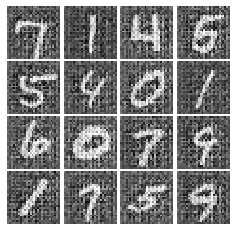


Iter: 250, D: 2.451e-05, G: 1.645, Adv: 0.1747, Per: 6.042
Prediction: [1, 1, 2, 1, 1, 8, 8, 1, 8, 8, 1, 8, 4, 3, 4, 1]
Target:     [4, 6, 4, 0, 3, 8, 5, 0, 3, 7, 8, 5, 9, 5, 3, 1]


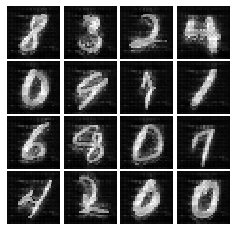


1 epoch, attack success rate: 7.759%

Iter: 500, D: 2.962e-05, G: 1.626, Adv: 0.1952, Per: 5.507
Prediction: [4, 5, 5, 3, 8, 4, 1, 3, 3, 8, 8, 3, 1, 2, 1, 3]
Target:     [9, 8, 4, 7, 1, 0, 4, 4, 4, 8, 7, 7, 9, 4, 0, 4]


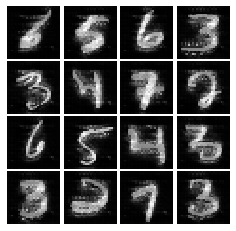


Iter: 750, D: 0.0, G: 1.786, Adv: 0.1652, Per: 5.268
Prediction: [8, 3, 1, 3, 1, 3, 3, 1, 3, 1, 8, 5, 1, 8, 3, 4]
Target:     [6, 4, 6, 5, 8, 1, 7, 2, 1, 4, 6, 4, 1, 3, 1, 6]


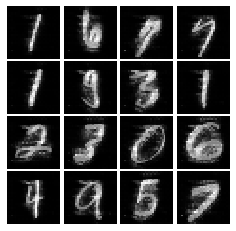


2 epoch, attack success rate: 21.78%

Iter: 1000, D: 0.0, G: 1.998, Adv: 0.1438, Per: 5.07
Prediction: [7, 3, 3, 7, 2, 3, 1, 2, 5, 2, 2, 1, 2, 3, 3, 1]
Target:     [7, 3, 3, 7, 2, 9, 1, 2, 5, 2, 0, 5, 2, 3, 8, 2]


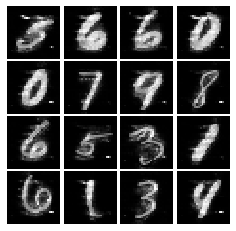


Iter: 1250, D: 0.0, G: 1.942, Adv: 0.1211, Per: 5.172
Prediction: [2, 1, 7, 1, 3, 0, 7, 3, 8, 9, 7, 0, 5, 7, 6, 8]
Target:     [2, 4, 7, 6, 3, 6, 7, 9, 8, 4, 7, 0, 8, 7, 0, 6]


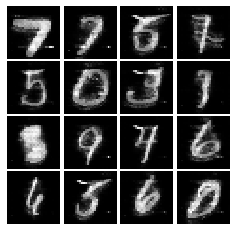


3 epoch, attack success rate: 48.17%

Iter: 1500, D: 1.18e-05, G: 1.899, Adv: 0.06396, Per: 5.136
Prediction: [4, 4, 8, 2, 8, 8, 1, 8, 9, 8, 5, 8, 1, 8, 2, 8]
Target:     [9, 4, 5, 2, 6, 8, 1, 8, 9, 8, 9, 9, 1, 6, 2, 8]


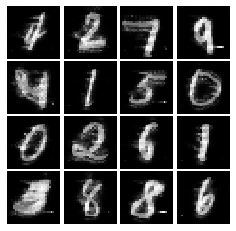


Iter: 1750, D: 0.0, G: 1.911, Adv: 0.07333, Per: 5.06
Prediction: [4, 7, 5, 5, 1, 1, 9, 8, 7, 9, 9, 8, 8, 8, 8, 9]
Target:     [0, 7, 6, 6, 1, 1, 9, 8, 7, 9, 9, 6, 8, 8, 6, 9]


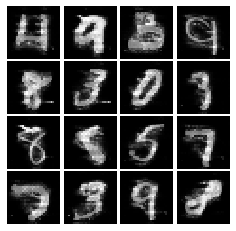


4 epoch, attack success rate: 67.05%

Iter: 2000, D: 0.0, G: 1.906, Adv: 0.04291, Per: 4.911
Prediction: [8, 7, 8, 9, 5, 2, 3, 5, 2, 8, 3, 7, 9, 6, 3, 1]
Target:     [8, 7, 0, 9, 5, 2, 3, 5, 2, 8, 5, 7, 9, 6, 3, 1]


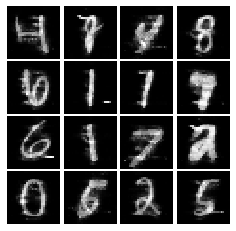


Iter: 2250, D: 0.0, G: 1.911, Adv: 0.05295, Per: 5.028
Prediction: [5, 8, 9, 8, 9, 6, 1, 3, 1, 5, 4, 8, 3, 0, 8, 5]
Target:     [5, 8, 9, 8, 9, 6, 1, 3, 1, 5, 4, 8, 3, 0, 8, 5]


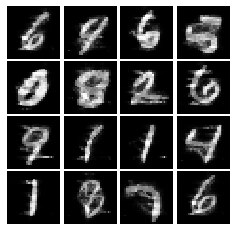


5 epoch, attack success rate: 83.49%

Iter: 2500, D: 0.0, G: 2.095, Adv: 0.07578, Per: 4.851
Prediction: [4, 5, 1, 2, 1, 3, 6, 8, 2, 7, 9, 3, 9, 1, 1, 9]
Target:     [4, 5, 1, 2, 1, 1, 6, 9, 2, 7, 9, 3, 9, 1, 1, 9]


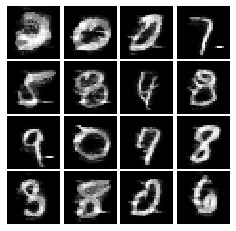


Iter: 2750, D: 0.0, G: 1.99, Adv: 0.04264, Per: 4.946
Prediction: [8, 6, 1, 6, 6, 7, 5, 7, 9, 3, 5, 7, 9, 9, 3, 1]
Target:     [8, 6, 1, 6, 0, 7, 6, 7, 9, 9, 5, 7, 9, 9, 3, 1]


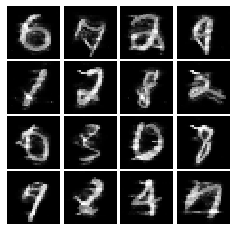


6 epoch, attack success rate: 91.23%

Iter: 3000, D: 0.0, G: 1.985, Adv: 0.02201, Per: 4.921
Prediction: [8, 3, 9, 9, 9, 1, 2, 7, 0, 3, 0, 9, 1, 7, 2, 2]
Target:     [8, 3, 9, 9, 9, 1, 2, 7, 0, 3, 0, 9, 1, 7, 2, 2]


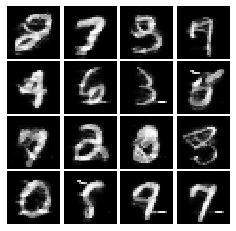


Iter: 3250, D: 0.0, G: 2.152, Adv: 0.006543, Per: 4.807
Prediction: [0, 2, 3, 6, 4, 9, 4, 3, 5, 5, 3, 0, 4, 1, 0, 8]
Target:     [0, 2, 3, 6, 4, 9, 4, 3, 5, 5, 3, 0, 4, 1, 0, 8]


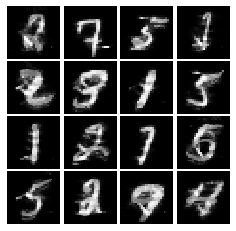


7 epoch, attack success rate: 93.41%

Iter: 3500, D: 0.0, G: 2.118, Adv: 0.05013, Per: 4.756
Prediction: [4, 5, 2, 9, 4, 2, 9, 9, 9, 5, 9, 9, 6, 5, 7, 7]
Target:     [4, 5, 2, 9, 4, 0, 9, 9, 9, 5, 9, 9, 6, 5, 7, 7]


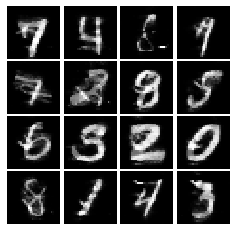


8 epoch, attack success rate: 94.69%

Iter: 3750, D: 0.0, G: 2.038, Adv: 0.03136, Per: 4.751
Prediction: [6, 8, 9, 3, 1, 2, 3, 3, 9, 1, 9, 8, 0, 2, 4, 7]
Target:     [6, 8, 9, 3, 1, 2, 3, 3, 9, 1, 9, 8, 0, 2, 4, 7]


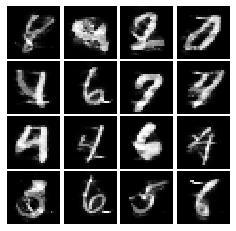


Iter: 4000, D: 0.0, G: 2.016, Adv: 0.1258, Per: 4.738
Prediction: [6, 4, 2, 2, 5, 0, 9, 2, 7, 0, 1, 1, 9, 9, 1, 6]
Target:     [6, 4, 2, 2, 5, 0, 4, 2, 7, 0, 1, 1, 9, 9, 1, 6]


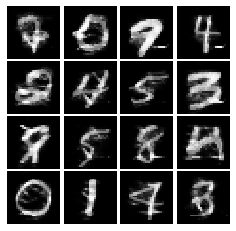


9 epoch, attack success rate: 95.36%

Iter: 4250, D: 0.0, G: 2.016, Adv: 0.05635, Per: 4.813
Prediction: [3, 1, 3, 6, 2, 6, 3, 7, 6, 0, 3, 8, 1, 3, 4, 8]
Target:     [3, 1, 3, 6, 2, 6, 3, 7, 6, 0, 3, 4, 6, 1, 4, 8]


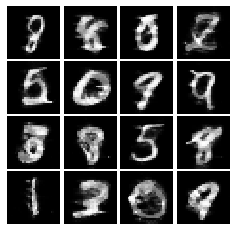


Iter: 4500, D: 0.0, G: 2.015, Adv: 0.04319, Per: 4.703
Prediction: [0, 7, 1, 9, 2, 0, 7, 9, 0, 3, 7, 6, 4, 1, 7, 8]
Target:     [0, 7, 1, 9, 2, 0, 7, 9, 0, 9, 7, 6, 4, 1, 7, 0]


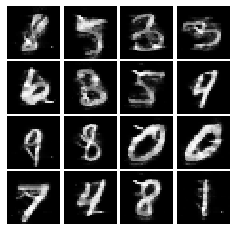


10 epoch, attack success rate: 95.76%

Iter: 4750, D: 0.0, G: 2.016, Adv: 0.03542, Per: 4.737
Prediction: [2, 2, 6, 4, 0, 4, 4, 1, 0, 8, 8, 1, 7, 3, 1, 1]
Target:     [2, 2, 6, 4, 0, 4, 4, 1, 0, 8, 8, 1, 7, 3, 1, 1]


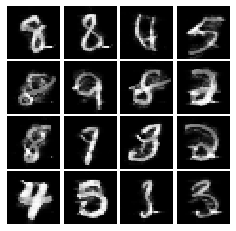


Iter: 5000, D: 0.0, G: 2.018, Adv: 0.02574, Per: 4.669
Prediction: [4, 4, 3, 3, 8, 5, 7, 2, 7, 8, 3, 0, 8, 5, 9, 0]
Target:     [4, 4, 3, 3, 8, 5, 7, 2, 7, 0, 6, 0, 8, 5, 9, 0]


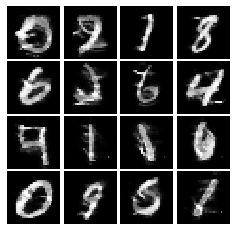


11 epoch, attack success rate: 96.2%

Iter: 5250, D: 0.0, G: 2.103, Adv: 0.04007, Per: 4.707
Prediction: [4, 7, 1, 3, 7, 5, 2, 8, 4, 8, 3, 3, 9, 5, 9, 9]
Target:     [4, 7, 1, 3, 7, 5, 2, 8, 4, 8, 3, 3, 9, 5, 9, 9]


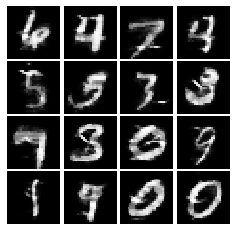


Iter: 5500, D: 0.0, G: 2.235, Adv: 0.008306, Per: 4.697
Prediction: [8, 2, 3, 8, 4, 8, 1, 4, 9, 4, 8, 1, 7, 1, 2, 0]
Target:     [8, 2, 3, 8, 4, 8, 1, 4, 9, 4, 8, 1, 7, 1, 2, 0]


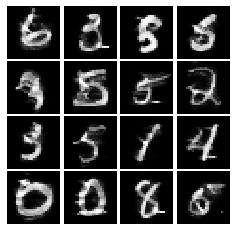


12 epoch, attack success rate: 96.47%

Iter: 5750, D: 0.0, G: 2.215, Adv: 0.02333, Per: 4.658
Prediction: [5, 3, 5, 4, 6, 9, 8, 4, 6, 7, 8, 5, 4, 5, 7, 7]
Target:     [5, 3, 5, 4, 6, 9, 8, 4, 6, 7, 8, 5, 4, 5, 7, 7]


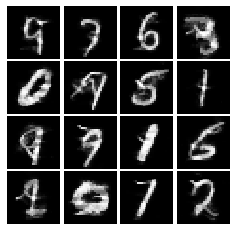


Iter: 6000, D: 0.0, G: 2.147, Adv: 0.04724, Per: 4.724
Prediction: [4, 5, 4, 8, 1, 3, 8, 0, 3, 1, 8, 9, 8, 0, 6, 1]
Target:     [4, 5, 4, 8, 1, 3, 8, 0, 3, 1, 8, 9, 8, 0, 6, 1]


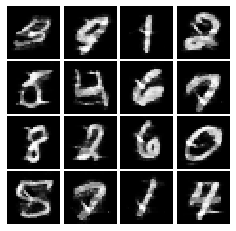


13 epoch, attack success rate: 96.76%

Iter: 6250, D: 0.0, G: 2.303, Adv: 0.03943, Per: 4.676
Prediction: [6, 9, 5, 5, 4, 8, 3, 5, 7, 0, 2, 1, 9, 5, 9, 0]
Target:     [6, 9, 5, 5, 4, 8, 3, 5, 7, 0, 2, 1, 9, 5, 4, 0]


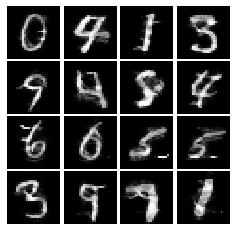


Iter: 6500, D: 0.0, G: 2.306, Adv: 0.03902, Per: 4.661
Prediction: [8, 8, 2, 1, 9, 6, 4, 4, 6, 6, 9, 4, 6, 2, 2, 2]
Target:     [8, 8, 2, 1, 9, 6, 4, 4, 6, 6, 9, 4, 6, 2, 2, 2]


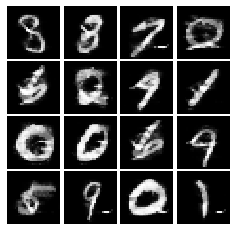


14 epoch, attack success rate: 96.79%

Iter: 6750, D: 0.0, G: 2.304, Adv: 0.03379, Per: 4.573
Prediction: [1, 8, 1, 2, 3, 4, 2, 3, 4, 0, 2, 2, 9, 3, 2, 5]
Target:     [1, 8, 0, 2, 6, 4, 2, 3, 4, 0, 2, 2, 9, 3, 2, 5]


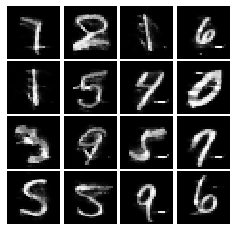


Iter: 7000, D: 0.0, G: 2.006, Adv: 0.02053, Per: 4.609
Prediction: [3, 3, 3, 2, 5, 8, 4, 2, 6, 0, 8, 7, 3, 8, 7, 1]
Target:     [3, 3, 3, 2, 5, 8, 4, 2, 6, 0, 8, 7, 3, 8, 7, 1]


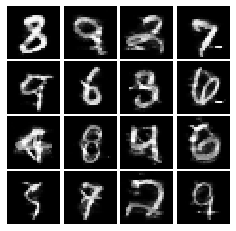


15 epoch, attack success rate: 96.98%

Iter: 7250, D: 0.0, G: 1.903, Adv: 0.02834, Per: 4.612
Prediction: [3, 9, 2, 0, 6, 1, 1, 3, 2, 6, 3, 0, 1, 4, 0, 5]
Target:     [3, 9, 2, 0, 6, 1, 1, 3, 2, 6, 3, 0, 0, 4, 0, 5]


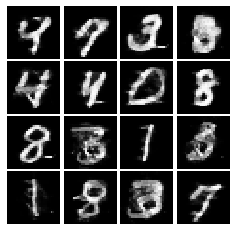


16 epoch, attack success rate: 97.25%

Iter: 7500, D: 0.0, G: 2.347, Adv: 0.02992, Per: 4.586
Prediction: [4, 0, 9, 7, 8, 8, 1, 1, 1, 2, 8, 2, 5, 6, 6, 6]
Target:     [4, 0, 9, 7, 8, 8, 1, 1, 1, 2, 8, 2, 5, 6, 6, 6]


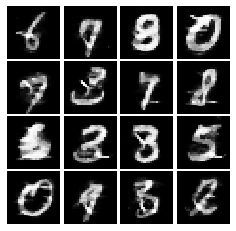


Iter: 7750, D: 0.0, G: 2.229, Adv: 0.02464, Per: 4.562
Prediction: [2, 9, 1, 9, 5, 5, 5, 5, 6, 0, 2, 4, 9, 2, 8, 9]
Target:     [2, 9, 1, 9, 5, 5, 5, 5, 6, 0, 2, 4, 9, 2, 8, 9]


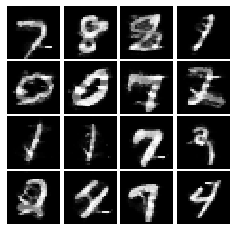


17 epoch, attack success rate: 97.22%

Iter: 8000, D: 0.0, G: 2.233, Adv: 0.01984, Per: 4.622
Prediction: [9, 3, 3, 8, 3, 6, 5, 2, 1, 3, 0, 7, 7, 3, 6, 5]
Target:     [9, 3, 3, 8, 3, 6, 5, 2, 1, 3, 0, 7, 7, 3, 6, 5]


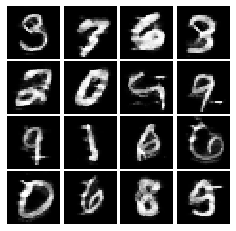


Iter: 8250, D: 0.0, G: 2.248, Adv: 0.01154, Per: 4.67
Prediction: [6, 0, 6, 0, 9, 7, 4, 5, 4, 1, 5, 8, 5, 2, 6, 6]
Target:     [6, 0, 6, 0, 9, 7, 4, 5, 4, 1, 5, 8, 5, 2, 6, 6]


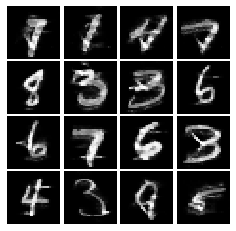


18 epoch, attack success rate: 97.36%

Iter: 8500, D: 0.0, G: 2.146, Adv: 0.03536, Per: 4.604
Prediction: [3, 9, 2, 9, 2, 4, 1, 5, 9, 2, 3, 9, 4, 6, 2, 9]
Target:     [3, 9, 2, 9, 2, 4, 1, 5, 9, 2, 3, 4, 4, 6, 2, 9]


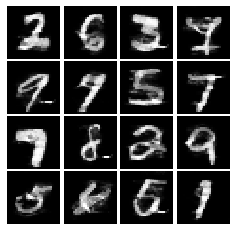


Iter: 8750, D: 0.0, G: 2.067, Adv: 0.02117, Per: 4.599
Prediction: [8, 4, 7, 9, 8, 3, 3, 5, 0, 8, 4, 4, 0, 3, 0, 2]
Target:     [8, 4, 7, 9, 8, 3, 3, 5, 0, 8, 4, 4, 0, 0, 0, 2]


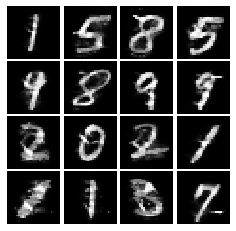


19 epoch, attack success rate: 97.55%

Iter: 9000, D: 0.0, G: 2.136, Adv: 0.04174, Per: 4.629
Prediction: [8, 4, 5, 5, 9, 2, 1, 0, 8, 3, 7, 7, 6, 8, 1, 9]
Target:     [8, 4, 5, 5, 9, 2, 1, 0, 8, 3, 7, 7, 6, 8, 1, 9]


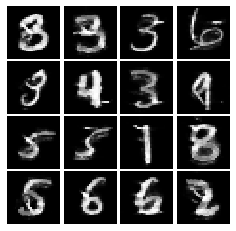


Iter: 9250, D: 0.0, G: 2.216, Adv: 0.02466, Per: 4.558
Prediction: [6, 5, 5, 0, 3, 0, 4, 0, 4, 7, 8, 4, 9, 8, 8, 5]
Target:     [6, 5, 5, 0, 3, 0, 4, 0, 4, 7, 8, 4, 9, 8, 8, 5]


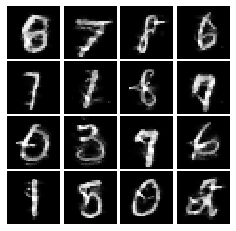


20 epoch, attack success rate: 97.62%



In [115]:
model = MNIST_model.model().type(dtype)
model.load_state_dict(torch.load('MNIST_weights'))

initialization_d = functools.partial(utils.initialize_weights, method='He', act='leaky_relu')
initialization_g = functools.partial(utils.initialize_weights, method='He')
adv_d_p_b = models.Discriminator().type(dtype)
adv_d_p_b.apply(initialization_d)
adv_g_u_b = models.Generator(use_dropout=True).type(dtype)
adv_g_u_b.apply(initialization_g)

adv_d_p_optimizer = torch.optim.Adam(adv_d_p_b.parameters(), lr=4e-4, betas=(0, 0.9))
adv_g_u_optimizer = torch.optim.Adam(adv_g_u_b.parameters(), lr=1e-4, betas=(0, 0.9))

loss, success_record = run_a_gan_modified(adv_d_p_b, adv_g_u_b, adv_d_p_optimizer, adv_g_u_optimizer, utils.discriminator_loss,
                                          utils.generator_loss, model, 0, 10, 5, num_epochs=20, lr_scheduler='linear')

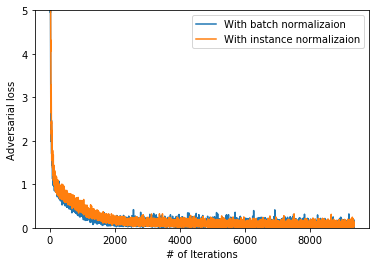

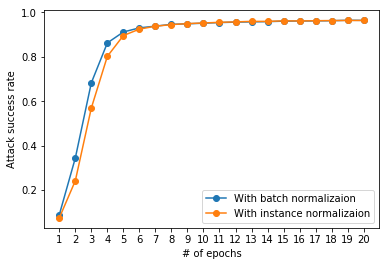

In [91]:
plt.xlabel('# of Iterations')
plt.ylabel('Adversarial loss')
plt.plot(loss, label='With batch normalizaion')
plt.plot(loss_ins, label='With instance normalizaion')
plt.ylim(0, 5)
plt.legend()
plt.savefig('batch_instance_loss.png')
plt.show()

plt.xlabel('# of epochs')
plt.ylabel('Attack success rate')
plt.plot(range(1, 21), success_record, '-o', label='With batch normalizaion')
plt.plot(range(1, 21), success_record_ins, '-o', label='With instance normalizaion')
plt.xticks(range(1, 21))
plt.legend()
plt.savefig('batch_instance_attack_success.png')
plt.show()

Prediction: [0, 3, 7, 3, 7, 4, 8, 8, 1, 0, 9, 9, 4, 9, 9, 0]
Target:     [0, 6, 7, 4, 7, 9, 8, 8, 1, 0, 9, 9, 4, 9, 9, 0]


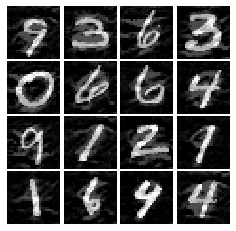

Attack success rate: 86.62%


In [87]:
success = 0
examples = 0
L_inf = 0.3
iteration = 0
adv_g_u.eval()
for x, y in loader_train:
    x = x.type(dtype)
    y = y.type(torch.cuda.LongTensor)
    rand_shift = torch.randint(low=1, high=10, size=(len(y), 1), device=cuda).squeeze()
    target_labels = ((y + rand_shift) % 10) 
    perturbation = torch.clamp(adv_g_u(x, target_labels), -L_inf, L_inf)
    fake_imgs = torch.clamp(perturbation + x, 0, 1.0)
    pred = model(fake_imgs).argmax(dim=1)
    success += (target_labels == pred).sum()
    examples += len(y)
    iteration += 1
    if iteration % 250 == 0:
        print('Prediction: {}'.format(pred.tolist()[0:16]))
        print('Target:     {}'.format(target_labels.tolist()[0:16]))
        utils.show_images(fake_imgs.detach().cpu().numpy()[0:16])
        plt.show()

print('Attack success rate: {:.4}%'.format(float(success) / examples * 100))

Prediction: [0, 2, 7, 9, 1, 0, 2, 2, 2, 4, 9, 7, 8, 6, 5, 4]
Target:     [0, 2, 7, 9, 1, 0, 2, 2, 2, 4, 9, 7, 8, 6, 5, 4]


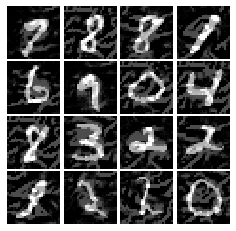

Attack success rate: 97.89%
Prediction: [8, 9, 3, 4, 0, 0, 7, 6, 6, 7, 4, 3, 5, 8, 2, 2]
Target:     [8, 9, 3, 4, 0, 0, 7, 6, 6, 7, 4, 3, 5, 8, 2, 2]


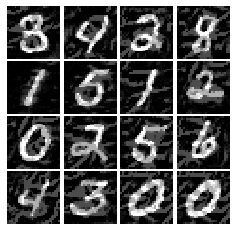

Attack success rate: 97.99%


In [141]:
success = 0
examples = 0
L_inf = 0.3
iteration = 0
adv_g_u_b.eval()
for x, y in loader_train:
    x = x.type(dtype)
    y = y.type(torch.cuda.LongTensor)
    rand_shift = torch.randint(low=1, high=10, size=(len(y), 1), device=cuda).squeeze()
    target_labels = ((y + rand_shift) % 10)
    perturbation = torch.clamp(adv_g_u_b(x, target_labels), -L_inf, L_inf)
    fake_imgs = torch.clamp(perturbation + x, 0, 1.0)
    pred = model(fake_imgs).argmax(dim=1)
    success += (target_labels == pred).sum()
    examples += len(y)
    iteration += 1
    if iteration % 250 == 0:
        print('Prediction: {}'.format(pred.tolist()[0:16]))
        print('Target:     {}'.format(target_labels.tolist()[0:16]))
        utils.show_images(fake_imgs.detach().cpu().numpy()[0:16])
        plt.show()
        
print('Attack success rate: {:.4}%'.format(float(success) / examples * 100))

adv_ex = np.empty((1, 784))
success = 0
examples = 0
iteration = 0
for x, y in loader_test:
    x = x.type(dtype)
    y = y.type(torch.cuda.LongTensor)
    rand_shift = torch.randint(low=1, high=10, size=(len(y), 1), device=cuda).squeeze()
    target_labels = ((y + rand_shift) % 10)
    perturbation = torch.clamp(adv_g_u_b(x, target_labels), -L_inf, L_inf)
    fake_imgs = torch.clamp(perturbation + x, 0, 1.0)
    pred = model(fake_imgs).argmax(dim=1)
    success += (target_labels == pred).sum()
    examples += len(y)
    adv_ex = np.concatenate((adv_ex, torch.flatten(fake_imgs.detach().cpu(), 1).numpy()), axis=0)
    iteration += 1
    if iteration % 50 == 0:
        print('Prediction: {}'.format(pred.tolist()[0:16]))
        print('Target:     {}'.format(target_labels.tolist()[0:16]))
        utils.show_images(fake_imgs.detach().cpu().numpy()[0:16])
        plt.show()
print('Attack success rate: {:.4}%'.format(float(success) / examples * 100))

Prediction: [2, 7, 6, 1, 3, 1, 7, 8, 3, 2, 8, 9, 2, 5, 3, 2]
Target:     [0, 7, 6, 1, 3, 1, 7, 8, 0, 2, 4, 9, 2, 5, 3, 2]


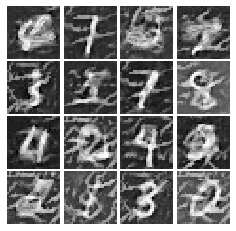

Attack success rate: 76.44%
Prediction: [3, 7, 3, 5, 5, 2, 5, 9, 9, 1, 7, 8, 8, 1, 9, 8]
Target:     [1, 7, 3, 5, 5, 0, 0, 9, 9, 0, 7, 8, 8, 0, 9, 8]


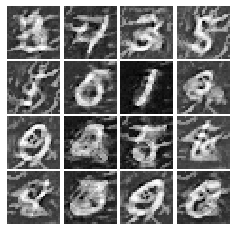

10000
Attack success rate: 76.63%


In [135]:
success = 0
examples = 0
L_inf = 0.3
iteration = 0
adv_g_u_b.train()
for x, y in loader_train:
    x = x.type(dtype)
    y = y.type(torch.cuda.LongTensor)
    rand_shift = torch.randint(low=1, high=10, size=(len(y), 1), device=cuda).squeeze()
    target_labels = ((y + rand_shift) % 10)
    fake_imgs = 1/2 * (torch.tanh(adv_g_u_b(x, target_labels).detach() + x) + 1)
    pred = model(fake_imgs).argmax(dim=1)
    success += (target_labels == pred).sum()
    examples += len(y)
    iteration += 1
    if iteration % 250 == 0:
        print('Prediction: {}'.format(pred.tolist()[0:16]))
        print('Target:     {}'.format(target_labels.tolist()[0:16]))
        utils.show_images(fake_imgs.detach().cpu().numpy()[0:16])
        plt.show()
        
print('Attack success rate: {:.4}%'.format(float(success) / examples * 100))

adv_ex = np.empty((1, 784))
success = 0
examples = 0
iteration = 0
for x, y in loader_test:
    x = x.type(dtype)
    y = y.type(torch.cuda.LongTensor)
    rand_shift = torch.randint(low=1, high=10, size=(len(y), 1), device=cuda).squeeze()
    target_labels = ((y + rand_shift) % 10)
    fake_imgs = 1/2 * (torch.tanh(adv_g_u_b(x, target_labels).detach() + x) + 1)
    pred = model(fake_imgs).argmax(dim=1)
    success += (target_labels == pred).sum()
    examples += len(y)
    adv_ex = np.concatenate((adv_ex, torch.flatten(fake_imgs.detach().cpu(), 1).numpy()), axis=0)
    iteration += 1
    if iteration % 50 == 0:
        print('Prediction: {}'.format(pred.tolist()[0:16]))
        print('Target:     {}'.format(target_labels.tolist()[0:16]))
        utils.show_images(fake_imgs.detach().cpu().numpy()[0:16])
        plt.show()
print('Attack success rate: {:.4}%'.format(float(success) / examples * 100))

In [143]:
# save the adversarial examples with numpy.save
import json

with open('mnist_challenge/config.json') as config_file:
    config = json.load(config_file)

# discard the first entry, because it's used to initialize the matrix.
adv_ex_out = adv_ex[1:]
path = config['store_adv_path']
np.save(path, adv_ex_out)

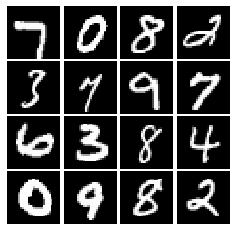

Prediction: [5, 6, 0, 5, 4, 5, 0, 3, 2, 0, 7, 2, 3, 2, 5, 5]
Target:     [5, 6, 0, 5, 4, 5, 0, 3, 2, 0, 7, 2, 3, 2, 5, 5]


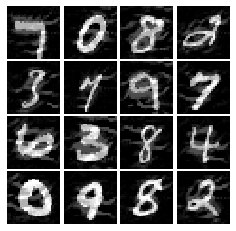

In [15]:
L_inf = 0.3
x, y = loader_train.__iter__().next()
x = x.type(dtype)
y = y.type(torch.cuda.LongTensor)
rand_shift = torch.randint(low=1, high=10, size=(len(y), 1), device=cuda).squeeze()
target_labels = ((y + rand_shift) % 10)
perturbation = torch.clamp(adv_g_u_b(x, target_labels), -L_inf, L_inf)
fake_imgs = torch.clamp(perturbation + x, 0, 1.0).detach()
pred = model(fake_imgs).argmax(dim=1)
utils.show_images(x.cpu().numpy()[0:16])
plt.show()
print('Prediction: {}'.format(pred.tolist()[0:16]))
print('Target:     {}'.format(target_labels.tolist()[0:16]))
utils.show_images(fake_imgs.cpu().numpy()[0:16])
plt.show()

Iter: 0, D: 2.012, G: -0.004304, Adv: 22.39, Per: 7.653
Prediction: [8, 6, 5, 7, 5, 7, 2, 1, 4, 7, 8, 5, 6, 2, 3, 7]
Target:     [0, 5, 9, 3, 0, 3, 4, 8, 5, 8, 1, 9, 7, 4, 9, 4]


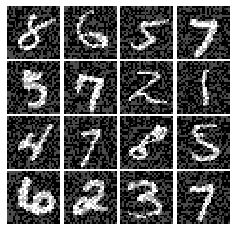


Iter: 250, D: 1.53, G: 1.785, Adv: 1.864, Per: 4.252
Prediction: [8, 8, 8, 1, 8, 8, 8, 8, 8, 7, 8, 5, 0, 9, 8, 7]
Target:     [2, 2, 1, 8, 4, 9, 9, 2, 0, 9, 3, 3, 8, 6, 5, 1]


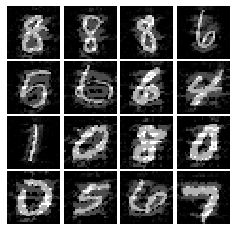


1 epoch, attack success rate: 9.991%

Iter: 500, D: 0.000143, G: 1.634, Adv: 1.82, Per: 3.549
Prediction: [8, 9, 2, 8, 1, 4, 8, 0, 8, 5, 9, 2, 5, 4, 9, 2]
Target:     [2, 9, 4, 3, 7, 9, 3, 1, 1, 5, 5, 2, 8, 7, 3, 2]


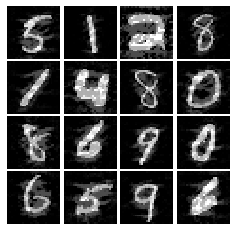


Iter: 750, D: 6.08e-05, G: 1.7, Adv: 0.9648, Per: 3.682
Prediction: [8, 9, 9, 5, 0, 7, 0, 8, 5, 8, 2, 8, 8, 2, 8, 5]
Target:     [8, 3, 9, 1, 6, 7, 0, 8, 4, 8, 2, 3, 8, 2, 8, 5]


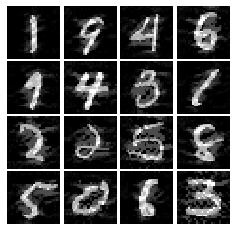


2 epoch, attack success rate: 49.8%

Iter: 1000, D: 0.02675, G: 1.56, Adv: 0.9289, Per: 3.574
Prediction: [9, 7, 8, 5, 8, 0, 4, 5, 1, 6, 2, 3, 8, 7, 0, 3]
Target:     [9, 3, 8, 5, 0, 0, 4, 5, 1, 6, 2, 3, 8, 1, 0, 9]


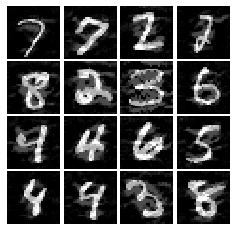


Iter: 1250, D: 8.395e-06, G: 1.855, Adv: 0.4866, Per: 3.441
Prediction: [5, 5, 4, 7, 3, 7, 1, 3, 1, 3, 4, 2, 7, 6, 3, 5]
Target:     [5, 5, 0, 7, 7, 7, 1, 1, 2, 8, 4, 2, 7, 6, 3, 6]


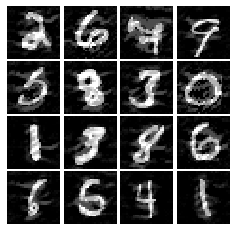


3 epoch, attack success rate: 71.72%

Iter: 1500, D: 0.4712, G: 0.9644, Adv: 0.3958, Per: 3.269
Prediction: [0, 4, 7, 4, 1, 2, 2, 2, 6, 2, 4, 4, 9, 9, 0, 6]
Target:     [0, 4, 7, 4, 1, 1, 2, 2, 6, 2, 4, 4, 1, 9, 0, 0]


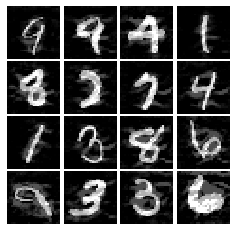


Iter: 1750, D: 3.558e-05, G: 1.881, Adv: 0.3428, Per: 3.19
Prediction: [6, 7, 0, 1, 5, 1, 4, 4, 7, 0, 9, 7, 7, 5, 5, 2]
Target:     [6, 7, 0, 1, 5, 1, 5, 4, 7, 0, 9, 7, 7, 5, 5, 2]


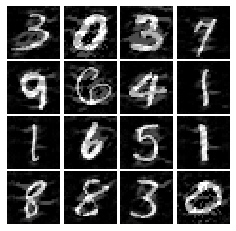


4 epoch, attack success rate: 77.26%

Iter: 2000, D: 9.658e-07, G: 2.047, Adv: 0.2589, Per: 3.132
Prediction: [8, 2, 8, 7, 5, 6, 7, 4, 2, 7, 8, 4, 2, 8, 1, 2]
Target:     [8, 2, 8, 7, 5, 6, 7, 4, 2, 7, 8, 1, 2, 8, 1, 2]


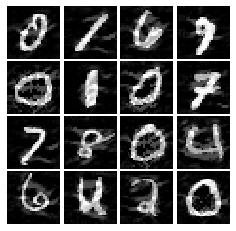


Iter: 2250, D: 0.0, G: 2.081, Adv: 0.549, Per: 3.124
Prediction: [4, 8, 1, 3, 5, 2, 8, 7, 8, 7, 9, 8, 5, 2, 7, 8]
Target:     [4, 8, 1, 3, 5, 2, 8, 7, 8, 7, 9, 8, 5, 6, 1, 8]


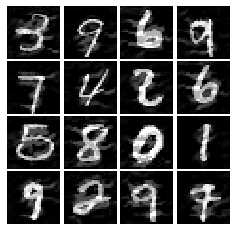


5 epoch, attack success rate: 79.86%

Iter: 2500, D: 0.0, G: 2.149, Adv: 0.2131, Per: 3.073
Prediction: [7, 2, 0, 2, 9, 8, 2, 6, 7, 4, 3, 7, 2, 5, 1, 6]
Target:     [7, 2, 0, 2, 1, 8, 2, 6, 1, 4, 3, 7, 2, 5, 1, 6]


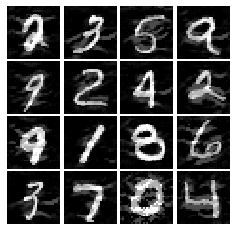


Iter: 2750, D: 0.0, G: 2.121, Adv: 0.2919, Per: 2.919
Prediction: [9, 7, 4, 1, 3, 5, 5, 3, 3, 4, 9, 3, 8, 2, 1, 9]
Target:     [9, 7, 4, 1, 3, 5, 5, 3, 3, 4, 9, 3, 8, 2, 1, 4]


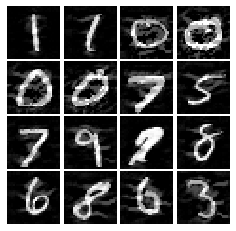


6 epoch, attack success rate: 81.36%

Iter: 3000, D: 0.0, G: 2.042, Adv: 0.5469, Per: 2.9
Prediction: [4, 6, 4, 9, 5, 3, 3, 7, 5, 8, 6, 6, 9, 6, 5, 8]
Target:     [4, 6, 2, 9, 5, 3, 3, 7, 5, 8, 6, 0, 9, 6, 5, 8]


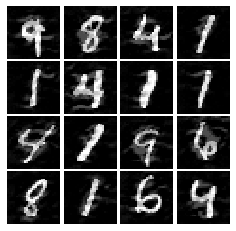


Iter: 3250, D: 0.0, G: 2.241, Adv: 0.2695, Per: 3.162
Prediction: [7, 9, 7, 1, 4, 2, 7, 9, 8, 2, 0, 1, 8, 4, 4, 7]
Target:     [7, 9, 7, 1, 4, 2, 7, 9, 8, 2, 0, 1, 8, 4, 1, 7]


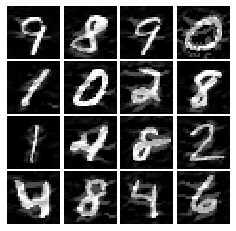


7 epoch, attack success rate: 82.56%

Iter: 3500, D: 0.0002334, G: 2.294, Adv: 0.399, Per: 2.868
Prediction: [6, 5, 0, 9, 2, 5, 4, 1, 6, 3, 7, 5, 3, 5, 8, 0]
Target:     [6, 5, 0, 9, 2, 9, 4, 1, 6, 3, 7, 9, 3, 5, 8, 0]


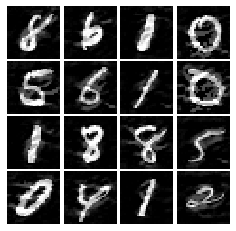


8 epoch, attack success rate: 83.54%

Iter: 3750, D: 0.0, G: 2.331, Adv: 0.259, Per: 2.979
Prediction: [3, 5, 8, 5, 6, 0, 0, 7, 3, 4, 4, 1, 0, 8, 8, 8]
Target:     [3, 5, 8, 5, 6, 0, 8, 7, 3, 6, 5, 1, 0, 8, 8, 8]


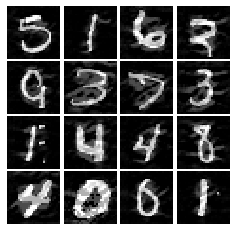


Iter: 4000, D: 3.141e-05, G: 2.158, Adv: 0.2801, Per: 2.923
Prediction: [2, 0, 3, 3, 2, 0, 8, 0, 9, 2, 3, 2, 4, 4, 1, 5]
Target:     [2, 0, 3, 3, 1, 6, 5, 0, 9, 2, 3, 2, 4, 4, 0, 5]


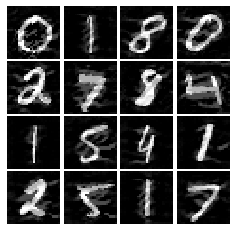


9 epoch, attack success rate: 83.51%

Iter: 4250, D: 0.0, G: 2.282, Adv: 0.4675, Per: 2.868
Prediction: [1, 5, 3, 9, 7, 8, 4, 0, 4, 4, 5, 5, 9, 1, 4, 0]
Target:     [1, 5, 3, 9, 7, 8, 4, 0, 4, 4, 5, 5, 9, 1, 4, 0]


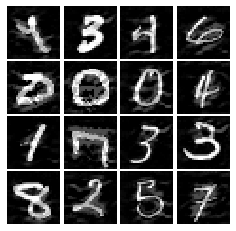

KeyboardInterrupt: 

In [67]:
initialization_d = functools.partial(utils.initialize_weights, method='He', act='leaky_relu')
initialization_g = functools.partial(utils.initialize_weights, method='He')
adv_d_p = models.Discriminator().type(dtype)
adv_d_p.apply(initialization_d)
adv_g_r = models.Generator(G_type='resnet').type(dtype)
adv_g_r.apply(initialization_g)

adv_d_p_optimizer = torch.optim.Adam(adv_d_p.parameters(), lr=4e-4, betas=(0.5, 0.9))
adv_g_r_optimizer = torch.optim.Adam(adv_g_r.parameters(), lr=1e-4, betas=(0.5, 0.9))

loss = run_a_gan_modified(adv_d_p, adv_g_r, adv_d_p_optimizer, adv_g_r_optimizer, discriminator_loss, generator_loss, model,
                   loss_fn, 0, 10, 5, num_epochs=20, lr_scheduler='linear')

Iter: 0, D: 1.994, G: 0.3335, Adv: 27.56, Per: 7.623
Prediction: [4, 7, 3, 1, 4, 2, 9, 5, 4, 9, 9, 6, 5, 1, 0, 2]
Target:     [5, 6, 4, 0, 6, 4, 1, 8, 6, 3, 5, 0, 9, 8, 4, 8]


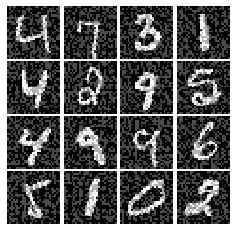


Iter: 250, D: 0.0005421, G: 2.429, Adv: 3.033, Per: 4.888
Prediction: [8, 7, 8, 2, 3, 9, 2, 5, 8, 8, 0, 9, 2, 7, 8, 9]
Target:     [9, 5, 1, 0, 3, 7, 6, 2, 5, 5, 6, 8, 6, 8, 9, 5]


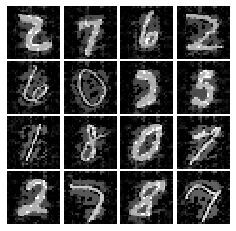


Iter: 500, D: 0.003644, G: 2.516, Adv: 1.645, Per: 4.546
Prediction: [8, 7, 0, 4, 7, 3, 9, 9, 4, 1, 3, 0, 3, 4, 4, 5]
Target:     [3, 5, 7, 4, 9, 8, 3, 3, 0, 1, 0, 8, 7, 6, 2, 5]


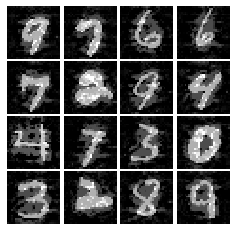


Iter: 750, D: 0.012, G: 2.526, Adv: 2.429, Per: 4.39
Prediction: [8, 0, 8, 3, 5, 5, 5, 5, 8, 1, 0, 5, 2, 9, 8, 9]
Target:     [3, 8, 3, 1, 1, 8, 0, 5, 1, 9, 7, 6, 2, 6, 2, 7]


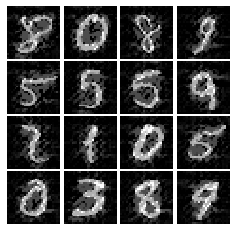


Iter: 1000, D: 0.0, G: 2.609, Adv: 1.682, Per: 4.074
Prediction: [7, 8, 6, 3, 6, 0, 2, 3, 3, 4, 0, 2, 3, 0, 8, 8]
Target:     [7, 6, 1, 3, 6, 8, 0, 7, 3, 7, 8, 2, 3, 8, 4, 1]


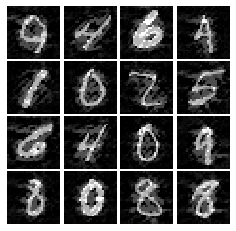


Iter: 1250, D: 0.002319, G: 2.566, Adv: 0.8381, Per: 3.908
Prediction: [5, 0, 3, 5, 9, 3, 8, 9, 9, 5, 3, 1, 4, 5, 1, 5]
Target:     [5, 0, 3, 5, 9, 3, 8, 6, 9, 5, 3, 1, 4, 5, 1, 5]


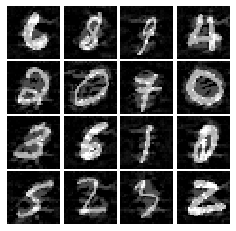


Iter: 1500, D: 0.006055, G: 2.51, Adv: 0.7927, Per: 3.897
Prediction: [6, 4, 7, 9, 1, 0, 0, 8, 8, 0, 9, 8, 7, 2, 3, 8]
Target:     [6, 4, 7, 5, 1, 0, 0, 8, 6, 0, 9, 8, 7, 2, 1, 8]


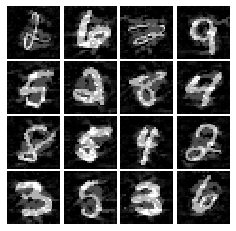


Iter: 1750, D: 0.0001058, G: 2.724, Adv: 0.2898, Per: 4.118
Prediction: [1, 9, 9, 7, 7, 2, 1, 9, 2, 8, 2, 5, 4, 4, 3, 3]
Target:     [1, 9, 9, 7, 7, 2, 1, 9, 2, 8, 2, 5, 4, 9, 3, 3]


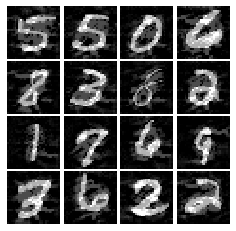


Iter: 2000, D: 0.007214, G: 1.947, Adv: 1.179, Per: 3.802
Prediction: [4, 8, 2, 7, 3, 4, 1, 7, 2, 4, 8, 5, 9, 4, 4, 0]
Target:     [4, 8, 2, 7, 9, 4, 1, 7, 2, 4, 5, 5, 9, 4, 4, 2]


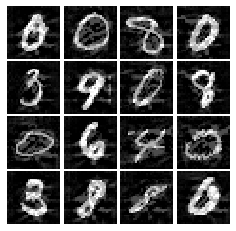


Iter: 2250, D: 0.0, G: 2.694, Adv: 0.2107, Per: 3.935
Prediction: [4, 5, 6, 6, 3, 4, 4, 3, 8, 8, 8, 9, 4, 3, 8, 9]
Target:     [4, 5, 6, 6, 3, 4, 4, 3, 8, 8, 8, 9, 4, 3, 6, 9]


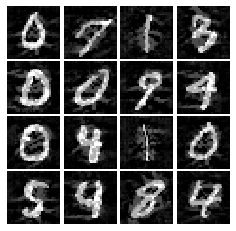


Iter: 2500, D: 0.0, G: 2.771, Adv: 0.5826, Per: 3.556
Prediction: [2, 6, 3, 5, 0, 7, 9, 4, 1, 8, 5, 6, 4, 6, 2, 3]
Target:     [2, 6, 3, 5, 0, 7, 9, 4, 1, 8, 5, 6, 9, 0, 2, 3]


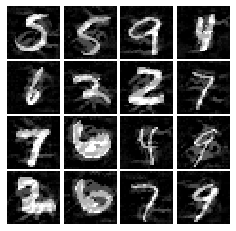


Iter: 2750, D: 0.0, G: 2.798, Adv: 0.482, Per: 3.622
Prediction: [9, 3, 2, 0, 5, 8, 9, 0, 8, 7, 9, 9, 8, 3, 3, 8]
Target:     [0, 7, 2, 0, 5, 8, 9, 0, 9, 7, 5, 9, 8, 3, 3, 8]


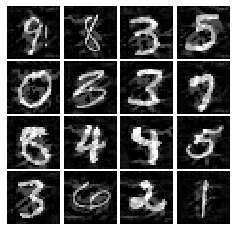


Iter: 3000, D: 0.0, G: 2.67, Adv: 0.3346, Per: 3.581
Prediction: [4, 8, 8, 3, 7, 4, 6, 3, 4, 2, 2, 2, 8, 1, 0, 9]
Target:     [4, 7, 6, 3, 7, 4, 6, 3, 4, 2, 2, 2, 0, 1, 0, 9]


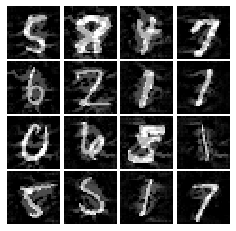


Iter: 3250, D: 0.0, G: 1.921, Adv: 0.4073, Per: 3.502
Prediction: [5, 5, 3, 4, 6, 0, 7, 0, 4, 2, 8, 7, 4, 8, 5, 1]
Target:     [5, 5, 1, 4, 6, 0, 7, 2, 4, 2, 8, 7, 4, 8, 5, 1]


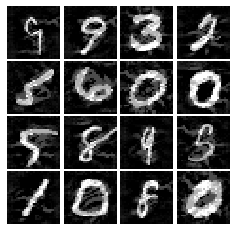


Iter: 3500, D: 0.0, G: 2.898, Adv: 0.1056, Per: 3.64
Prediction: [8, 2, 1, 4, 5, 7, 4, 7, 7, 8, 7, 5, 1, 7, 0, 6]
Target:     [8, 2, 1, 4, 5, 7, 4, 7, 7, 8, 7, 5, 1, 7, 0, 6]


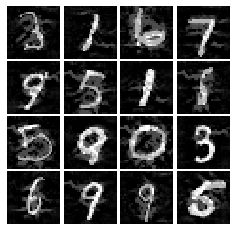


Iter: 3750, D: 0.0, G: 2.571, Adv: 0.2424, Per: 3.61
Prediction: [0, 6, 8, 9, 3, 1, 7, 5, 0, 3, 6, 9, 2, 8, 8, 4]
Target:     [0, 6, 8, 9, 3, 1, 7, 5, 0, 3, 6, 9, 2, 8, 8, 7]


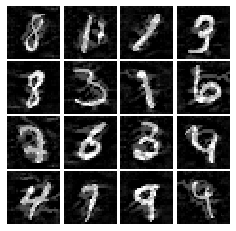


Iter: 4000, D: 0.0, G: 2.703, Adv: 0.403, Per: 3.351
Prediction: [2, 2, 9, 5, 0, 3, 5, 1, 1, 4, 5, 3, 4, 3, 6, 7]
Target:     [2, 2, 9, 5, 0, 3, 5, 1, 1, 4, 5, 3, 1, 3, 6, 7]


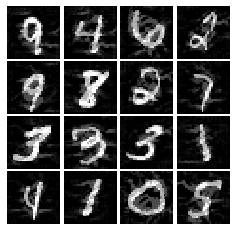


Iter: 4250, D: 0.0, G: 2.905, Adv: 0.2746, Per: 3.289
Prediction: [5, 1, 2, 7, 0, 0, 6, 0, 6, 5, 4, 9, 9, 4, 4, 9]
Target:     [5, 4, 8, 7, 0, 0, 6, 0, 6, 5, 4, 9, 9, 4, 4, 9]


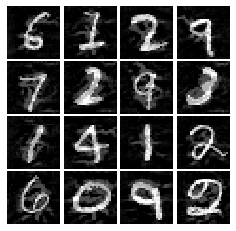


Iter: 4500, D: 0.0, G: 2.234, Adv: 0.3986, Per: 3.317
Prediction: [1, 5, 0, 3, 8, 6, 6, 0, 2, 4, 5, 4, 7, 0, 4, 0]
Target:     [1, 6, 0, 3, 8, 6, 6, 0, 2, 4, 5, 1, 7, 0, 4, 0]


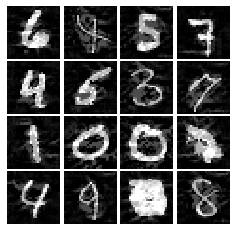


Iter: 4750, D: 0.005731, G: 2.856, Adv: 0.3065, Per: 3.47
Prediction: [4, 7, 6, 5, 4, 7, 9, 8, 1, 8, 8, 8, 9, 6, 5, 0]
Target:     [4, 7, 6, 5, 4, 7, 7, 8, 1, 8, 8, 8, 9, 6, 5, 6]


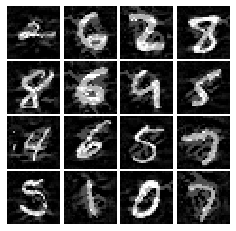


Iter: 5000, D: 0.0, G: 2.89, Adv: 0.3283, Per: 3.322
Prediction: [5, 8, 4, 3, 2, 8, 6, 2, 0, 0, 2, 5, 3, 6, 3, 3]
Target:     [5, 6, 4, 3, 2, 8, 6, 2, 0, 0, 2, 3, 3, 6, 3, 5]


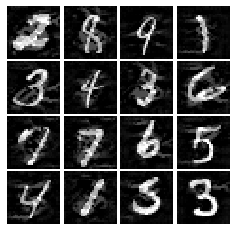


Iter: 5250, D: 0.0, G: 2.632, Adv: 0.2262, Per: 3.506
Prediction: [1, 7, 4, 9, 2, 0, 4, 6, 1, 5, 6, 4, 3, 7, 5, 3]
Target:     [1, 7, 4, 9, 2, 0, 4, 6, 1, 9, 4, 4, 9, 7, 5, 3]


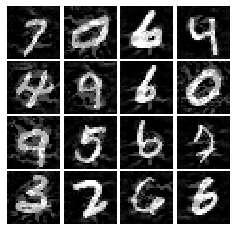


Iter: 5500, D: 0.0, G: 2.936, Adv: 0.4935, Per: 3.264
Prediction: [2, 4, 0, 8, 8, 2, 7, 3, 8, 8, 2, 2, 7, 4, 3, 5]
Target:     [4, 4, 0, 8, 8, 2, 7, 3, 8, 8, 2, 2, 7, 4, 3, 5]


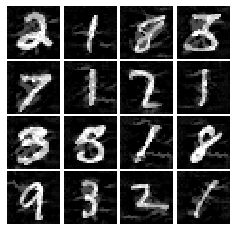


Iter: 5750, D: 0.001016, G: 2.85, Adv: 0.492, Per: 3.061
Prediction: [2, 3, 2, 2, 9, 4, 6, 4, 2, 1, 9, 2, 9, 3, 4, 6]
Target:     [2, 3, 2, 2, 9, 4, 6, 4, 0, 1, 9, 2, 9, 3, 4, 6]


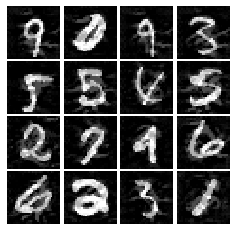


Iter: 6000, D: 0.0, G: 3.025, Adv: 0.08976, Per: 3.491
Prediction: [4, 7, 2, 9, 2, 8, 7, 5, 0, 5, 3, 2, 5, 6, 4, 5]
Target:     [4, 7, 2, 9, 2, 8, 7, 5, 0, 5, 3, 2, 5, 6, 4, 5]


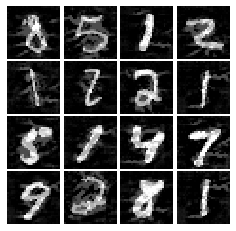


Iter: 6250, D: 0.0, G: 2.544, Adv: 0.318, Per: 3.396
Prediction: [0, 2, 0, 8, 2, 3, 9, 1, 0, 7, 2, 2, 8, 8, 6, 7]
Target:     [0, 2, 6, 8, 2, 3, 9, 1, 5, 7, 0, 2, 8, 8, 6, 7]


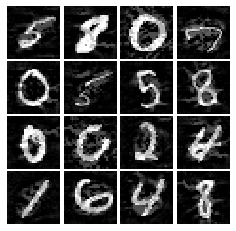


Iter: 6500, D: 0.0, G: 2.645, Adv: 0.3422, Per: 3.338
Prediction: [1, 3, 3, 6, 8, 7, 5, 4, 4, 9, 4, 1, 2, 5, 7, 8]
Target:     [1, 2, 3, 8, 8, 7, 5, 4, 4, 9, 4, 1, 2, 5, 7, 8]


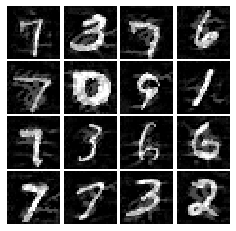


Iter: 6750, D: 0.01757, G: 2.81, Adv: 0.1935, Per: 3.38
Prediction: [7, 6, 0, 8, 6, 4, 6, 2, 2, 2, 6, 3, 6, 5, 3, 4]
Target:     [7, 6, 0, 8, 6, 4, 6, 2, 8, 2, 6, 3, 6, 5, 3, 4]


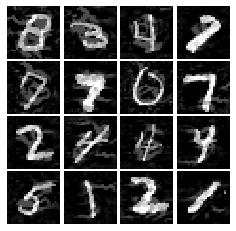


Iter: 7000, D: 0.0, G: 2.589, Adv: 0.3483, Per: 3.349
Prediction: [7, 4, 0, 3, 8, 8, 0, 4, 4, 1, 0, 3, 8, 8, 6, 7]
Target:     [7, 4, 0, 3, 8, 8, 0, 4, 4, 1, 0, 7, 8, 8, 6, 7]


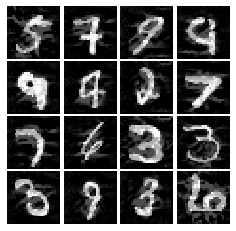

In [16]:
initialization_d = functools.partial(utils.initialize_weights, method='He', act='leaky_relu')
initialization_g = functools.partial(utils.initialize_weights, method='He')
adv_d_p = models.Discriminator().type(dtype)
adv_d_p.apply(initialization_d)
adv_g_u = models.Generator(G_type='resnet', norm='instance').type(dtype)
adv_g_u.apply(initialization_g)

adv_d_p_optimizer = torch.optim.Adam(adv_d_p.parameters(), lr=4e-4, betas=(0.5, 0.9))
adv_g_u_optimizer = torch.optim.Adam(adv_g_u.parameters(), lr=1e-4, betas=(0.5, 0.9))

loss_r_i = run_a_gan_modified(adv_d_p, adv_g_u, adv_d_p_optimizer, adv_g_u_optimizer, discriminator_loss, generator_loss, model,
                   loss_fn, 0, 10, 5, num_epochs=20, lr_scheduler='linear')

Iter: 0, D: 0.5801, G: 0.3146, Adv: 36.04, Per: 8.542
Prediction: [7, 4, 1, 4, 5, 1, 1, 9, 9, 9, 1, 5, 5, 7, 9, 3]
Target:     [4, 1, 8, 7, 4, 4, 6, 2, 0, 3, 0, 9, 1, 8, 6, 1]


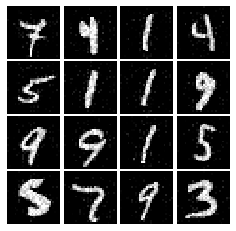


Iter: 250, D: 0.01717, G: 0.4964, Adv: 3.22, Per: 7.619
Prediction: [4, 8, 2, 9, 0, 1, 0, 2, 3, 5, 6, 3, 9, 0, 0, 8]
Target:     [9, 6, 1, 5, 1, 0, 3, 4, 0, 8, 1, 1, 8, 4, 7, 7]


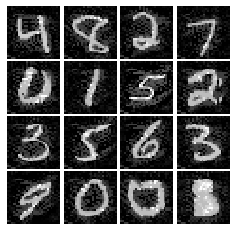


Iter: 500, D: 0.007299, G: 0.5032, Adv: 2.782, Per: 7.175
Prediction: [8, 0, 1, 8, 9, 2, 6, 1, 1, 2, 8, 8, 3, 8, 2, 5]
Target:     [3, 7, 7, 9, 2, 8, 7, 5, 7, 8, 5, 8, 9, 5, 4, 2]


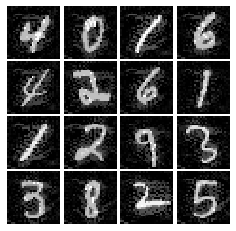


Iter: 750, D: 0.002526, G: 0.4922, Adv: 2.781, Per: 7.14
Prediction: [1, 3, 9, 3, 4, 8, 0, 8, 0, 9, 8, 0, 8, 8, 8, 2]
Target:     [9, 4, 4, 3, 2, 5, 8, 0, 9, 7, 8, 2, 1, 2, 3, 4]


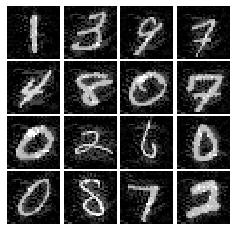


Iter: 1000, D: 0.001534, G: 0.498, Adv: 2.474, Per: 7.024
Prediction: [9, 9, 6, 2, 8, 7, 1, 1, 0, 5, 8, 3, 3, 8, 8, 8]
Target:     [2, 1, 5, 4, 0, 6, 0, 0, 8, 2, 7, 2, 2, 0, 5, 7]


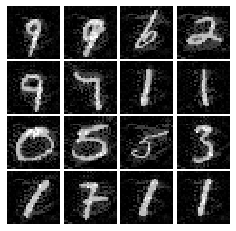


Iter: 1250, D: 0.000993, G: 0.4971, Adv: 2.307, Per: 7.024
Prediction: [5, 4, 8, 6, 9, 5, 5, 3, 8, 6, 2, 8, 4, 2, 0, 0]
Target:     [2, 0, 3, 4, 6, 3, 2, 7, 5, 5, 7, 0, 9, 1, 1, 1]


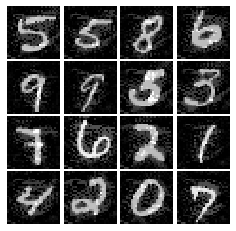


Iter: 1500, D: 0.001338, G: 0.4891, Adv: 1.937, Per: 6.876
Prediction: [8, 8, 9, 6, 9, 4, 8, 8, 9, 1, 9, 9, 8, 8, 6, 8]
Target:     [8, 9, 4, 0, 3, 9, 4, 3, 9, 4, 6, 4, 5, 8, 5, 8]


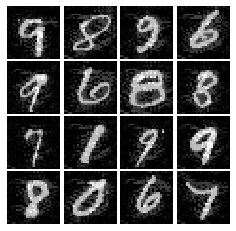


Iter: 1750, D: 0.001088, G: 0.5012, Adv: 1.782, Per: 6.749
Prediction: [8, 9, 2, 9, 5, 3, 7, 5, 1, 2, 5, 0, 2, 5, 7, 8]
Target:     [8, 9, 4, 1, 8, 3, 3, 2, 0, 2, 4, 5, 0, 5, 9, 5]


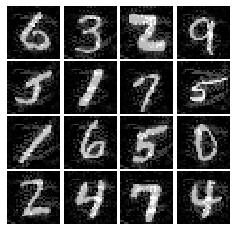


Iter: 2000, D: 0.0008181, G: 0.5045, Adv: 2.315, Per: 6.962
Prediction: [9, 2, 2, 0, 7, 8, 6, 5, 2, 2, 2, 3, 8, 8, 3, 2]
Target:     [2, 1, 7, 5, 0, 7, 3, 8, 9, 7, 2, 8, 9, 8, 3, 7]


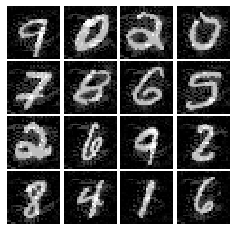


Iter: 2250, D: 0.000638, G: 0.4972, Adv: 1.789, Per: 6.726
Prediction: [9, 0, 5, 9, 2, 9, 5, 8, 8, 2, 9, 3, 2, 2, 2, 2]
Target:     [1, 7, 5, 7, 0, 8, 2, 1, 8, 4, 4, 7, 7, 1, 2, 5]


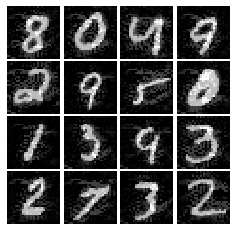


Iter: 2500, D: 0.0008432, G: 0.4992, Adv: 1.67, Per: 6.616
Prediction: [1, 3, 9, 6, 2, 0, 0, 8, 9, 1, 0, 9, 8, 6, 6, 2]
Target:     [3, 6, 6, 3, 1, 9, 1, 8, 4, 7, 1, 4, 9, 0, 8, 4]


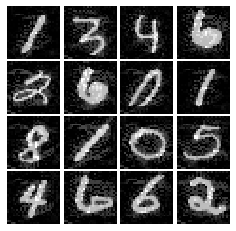


Iter: 2750, D: 0.001145, G: 0.4989, Adv: 1.812, Per: 6.825
Prediction: [9, 0, 2, 8, 6, 8, 6, 5, 9, 4, 8, 8, 9, 3, 3, 0]
Target:     [9, 1, 2, 8, 0, 9, 3, 5, 4, 0, 5, 2, 7, 8, 6, 0]


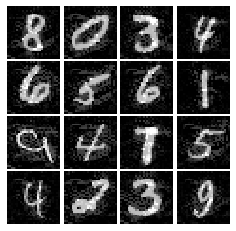


Iter: 3000, D: 0.0008221, G: 0.4993, Adv: 1.485, Per: 6.622
Prediction: [8, 4, 1, 2, 3, 8, 3, 2, 0, 9, 5, 3, 4, 9, 8, 7]
Target:     [1, 4, 4, 2, 3, 6, 7, 4, 9, 3, 5, 6, 9, 8, 8, 7]


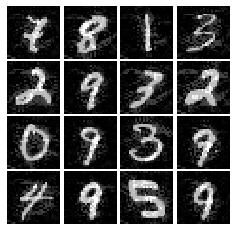


Iter: 3250, D: 0.000309, G: 0.5004, Adv: 1.821, Per: 6.848
Prediction: [9, 9, 8, 9, 8, 8, 0, 0, 1, 8, 2, 9, 0, 9, 7, 2]
Target:     [0, 4, 8, 4, 8, 6, 0, 9, 4, 3, 2, 9, 1, 7, 5, 2]


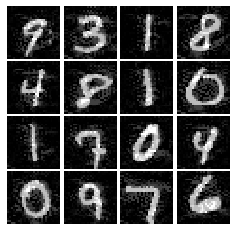


Iter: 3500, D: 0.0004995, G: 0.4995, Adv: 1.742, Per: 6.511
Prediction: [4, 2, 7, 8, 2, 3, 3, 8, 7, 0, 3, 2, 5, 3, 1, 3]
Target:     [6, 2, 7, 0, 6, 3, 1, 5, 1, 1, 7, 7, 5, 4, 9, 1]


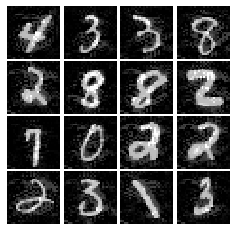


Iter: 3750, D: 0.0004935, G: 0.4985, Adv: 1.444, Per: 6.541
Prediction: [2, 2, 5, 4, 8, 0, 3, 3, 9, 5, 1, 9, 9, 4, 5, 7]
Target:     [8, 2, 5, 4, 8, 7, 9, 3, 1, 6, 7, 9, 0, 4, 5, 7]


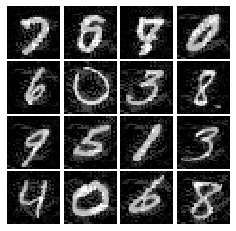


Iter: 4000, D: 0.0004158, G: 0.4975, Adv: 1.436, Per: 6.66
Prediction: [3, 8, 4, 8, 1, 2, 5, 9, 2, 0, 4, 4, 3, 4, 8, 2]
Target:     [9, 2, 2, 6, 4, 6, 5, 9, 0, 1, 7, 4, 1, 4, 6, 7]


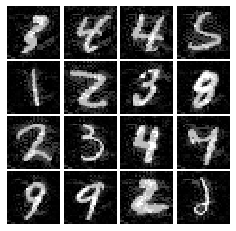


Iter: 4250, D: 0.0003718, G: 0.4992, Adv: 1.414, Per: 6.457
Prediction: [2, 8, 3, 4, 8, 3, 9, 1, 2, 0, 2, 7, 8, 9, 8, 1]
Target:     [2, 8, 6, 4, 2, 3, 9, 1, 2, 0, 1, 7, 6, 3, 0, 8]


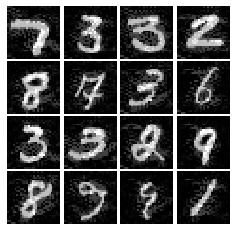


Iter: 4500, D: 0.0002861, G: 0.5005, Adv: 1.551, Per: 6.374
Prediction: [0, 0, 5, 5, 0, 2, 2, 9, 7, 3, 0, 8, 0, 9, 8, 0]
Target:     [5, 3, 5, 5, 0, 0, 8, 7, 1, 9, 0, 7, 6, 4, 1, 0]


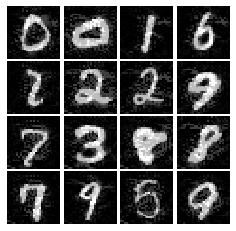


Iter: 4750, D: 0.00042, G: 0.4984, Adv: 1.381, Per: 6.395
Prediction: [8, 5, 9, 3, 3, 9, 5, 5, 3, 3, 9, 8, 4, 8, 8, 7]
Target:     [6, 8, 9, 3, 3, 9, 5, 5, 6, 6, 8, 8, 8, 0, 8, 1]


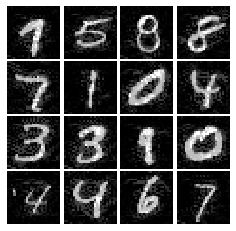


Iter: 5000, D: 0.0002383, G: 0.502, Adv: 1.406, Per: 6.512
Prediction: [9, 3, 1, 8, 5, 2, 5, 5, 2, 4, 8, 0, 7, 3, 0, 5]
Target:     [9, 3, 4, 6, 7, 4, 5, 5, 0, 1, 6, 0, 7, 1, 0, 1]


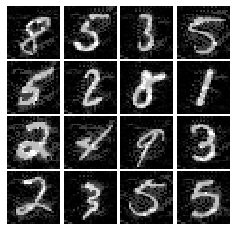


Iter: 5250, D: 0.0002395, G: 0.499, Adv: 1.279, Per: 6.434
Prediction: [2, 6, 4, 9, 2, 9, 8, 5, 9, 9, 9, 4, 8, 8, 3, 2]
Target:     [2, 6, 9, 9, 2, 9, 6, 5, 9, 9, 3, 4, 3, 6, 7, 2]


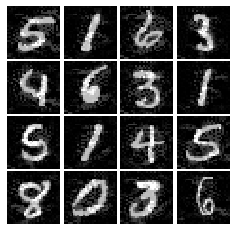


Iter: 5500, D: 0.0001883, G: 0.5005, Adv: 1.694, Per: 6.627
Prediction: [8, 2, 0, 9, 8, 8, 8, 5, 0, 8, 2, 8, 8, 3, 5, 4]
Target:     [5, 5, 0, 9, 4, 5, 8, 5, 6, 8, 2, 7, 1, 4, 9, 1]


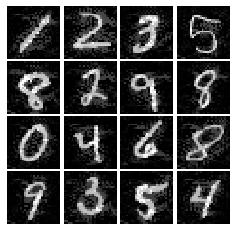


Iter: 5750, D: 0.0003675, G: 0.4984, Adv: 1.287, Per: 6.53
Prediction: [8, 5, 8, 0, 4, 8, 8, 5, 0, 8, 2, 9, 2, 3, 3, 8]
Target:     [6, 5, 8, 8, 4, 6, 3, 5, 7, 4, 2, 6, 1, 0, 3, 3]


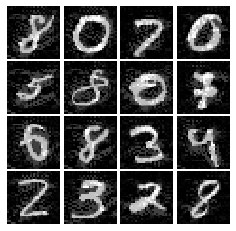


Iter: 6000, D: 0.0003038, G: 0.4974, Adv: 1.36, Per: 6.442
Prediction: [3, 8, 0, 4, 7, 8, 7, 0, 7, 2, 3, 2, 4, 5, 2, 5]
Target:     [9, 9, 7, 9, 4, 8, 7, 0, 2, 2, 3, 1, 9, 5, 2, 5]


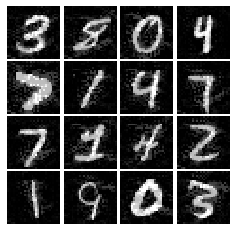


Iter: 6250, D: 0.0005871, G: 0.5028, Adv: 1.07, Per: 6.417
Prediction: [5, 3, 0, 8, 8, 3, 5, 4, 8, 4, 8, 2, 8, 4, 8, 8]
Target:     [5, 3, 7, 1, 8, 3, 5, 4, 8, 7, 8, 1, 6, 6, 3, 8]


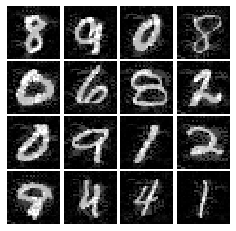


Iter: 6500, D: 0.0002705, G: 0.5023, Adv: 1.218, Per: 6.391
Prediction: [2, 7, 5, 9, 2, 3, 9, 8, 9, 4, 2, 2, 6, 3, 2, 6]
Target:     [2, 7, 5, 0, 2, 3, 9, 8, 9, 4, 7, 7, 1, 2, 2, 3]


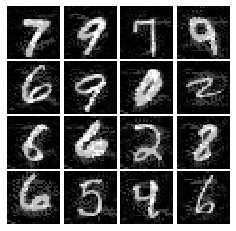


Iter: 6750, D: 0.000123, G: 0.5002, Adv: 1.281, Per: 6.571
Prediction: [1, 3, 2, 3, 3, 5, 9, 2, 2, 2, 3, 3, 9, 2, 0, 0]
Target:     [1, 3, 0, 1, 8, 5, 7, 2, 1, 9, 7, 1, 8, 2, 0, 0]


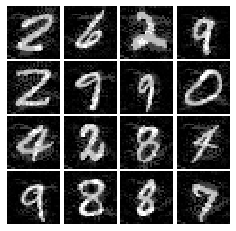


Iter: 7000, D: 0.0006343, G: 0.4973, Adv: 1.08, Per: 6.129
Prediction: [5, 0, 8, 4, 0, 5, 9, 6, 8, 3, 8, 2, 9, 5, 2, 0]
Target:     [5, 6, 3, 0, 0, 5, 1, 5, 8, 3, 9, 2, 1, 5, 2, 0]


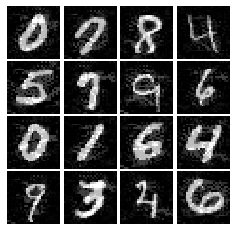


Iter: 7250, D: 0.0001904, G: 0.4998, Adv: 1.246, Per: 6.228
Prediction: [6, 2, 8, 2, 3, 2, 8, 9, 8, 8, 7, 6, 2, 9, 3, 9]
Target:     [6, 9, 9, 2, 3, 2, 1, 6, 8, 5, 7, 6, 1, 3, 3, 9]


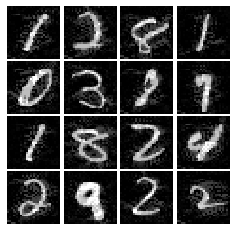


Iter: 7500, D: 0.0001909, G: 0.5007, Adv: 1.316, Per: 6.281
Prediction: [5, 1, 9, 2, 8, 4, 1, 2, 2, 2, 8, 2, 2, 8, 6, 5]
Target:     [5, 1, 9, 2, 8, 4, 4, 7, 2, 2, 0, 2, 2, 2, 6, 8]


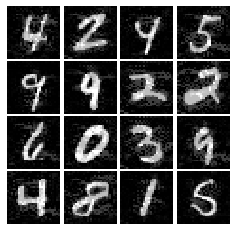


Iter: 7750, D: 0.0002043, G: 0.5022, Adv: 1.245, Per: 6.481
Prediction: [4, 0, 5, 4, 0, 2, 8, 5, 5, 4, 0, 3, 0, 3, 4, 4]
Target:     [9, 6, 5, 4, 0, 2, 8, 5, 5, 2, 0, 3, 6, 5, 1, 4]


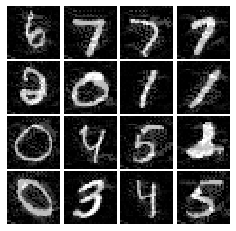


Iter: 8000, D: 0.000174, G: 0.5, Adv: 1.023, Per: 6.14
Prediction: [6, 5, 5, 9, 3, 8, 7, 8, 9, 2, 7, 0, 2, 4, 8, 3]
Target:     [0, 5, 9, 9, 1, 3, 7, 8, 9, 7, 7, 0, 2, 4, 1, 3]


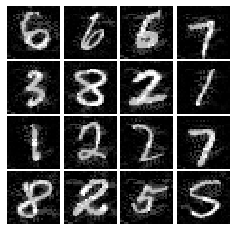


Iter: 8250, D: 0.0002871, G: 0.4985, Adv: 1.127, Per: 6.219
Prediction: [3, 8, 3, 0, 8, 6, 1, 2, 2, 2, 5, 9, 6, 2, 3, 3]
Target:     [3, 7, 3, 0, 2, 6, 3, 9, 2, 2, 5, 4, 0, 2, 3, 3]


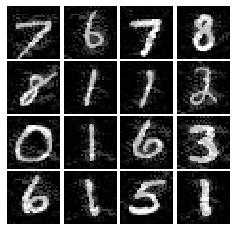


Iter: 8500, D: 9.917e-05, G: 0.5012, Adv: 1.076, Per: 6.329
Prediction: [2, 0, 9, 0, 7, 5, 2, 4, 3, 8, 2, 2, 0, 7, 2, 9]
Target:     [2, 0, 0, 0, 7, 5, 3, 9, 3, 8, 2, 2, 0, 7, 2, 9]


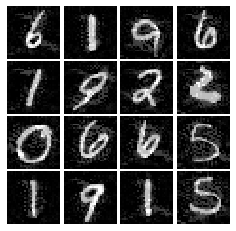


Iter: 8750, D: 0.0002775, G: 0.5, Adv: 1.216, Per: 6.477
Prediction: [6, 8, 3, 3, 7, 7, 3, 1, 3, 4, 3, 7, 8, 3, 2, 0]
Target:     [5, 8, 6, 3, 1, 8, 3, 1, 3, 4, 7, 7, 0, 6, 2, 7]


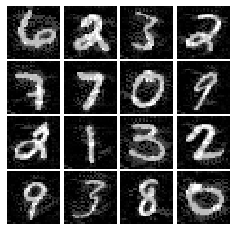


Iter: 9000, D: 0.0001355, G: 0.5001, Adv: 1.078, Per: 6.202
Prediction: [2, 9, 2, 2, 4, 6, 8, 9, 2, 8, 8, 5, 2, 8, 9, 8]
Target:     [2, 7, 0, 1, 2, 5, 5, 9, 2, 6, 6, 1, 2, 8, 9, 7]


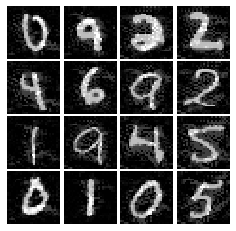


Iter: 9250, D: 0.0001536, G: 0.5004, Adv: 1.071, Per: 6.438
Prediction: [4, 0, 6, 8, 4, 0, 4, 5, 5, 5, 2, 5, 8, 9, 0, 4]
Target:     [4, 0, 6, 0, 9, 6, 4, 5, 5, 5, 6, 2, 1, 7, 1, 0]


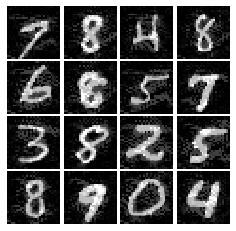

In [61]:
import models

initialization_d = functools.partial(utils.initialize_weights, method='He', act='leaky_relu')
initialization_g = functools.partial(utils.initialize_weights, method='He')
adv_d_p = models.Discriminator().type(dtype)
adv_d_p.apply(initialization_d)
adv_g_u = models.Generator(G_type='resnet', norm='instance').type(dtype)
adv_g_u.apply(initialization_g)

adv_d_p_optimizer = torch.optim.Adam(adv_d_p.parameters(), lr=1e-4, betas=(0.5, 0.9))
adv_g_u_optimizer = torch.optim.Adam(adv_g_u.parameters(), lr=1e-4, betas=(0.5, 0.9))

run_a_gan_modified(adv_d_p, adv_g_u, adv_d_p_optimizer, adv_g_u_optimizer, discriminator_loss_LS, generator_loss_LS, model,
                   loss_fn, 0, 10, 5, num_epochs=20, lr_scheduler='linear')

# TODO
* Instance normalization?
* Benchmarking
* ResnetGenerator
* Maybe CIFAR10
* AlexNet, VGG, mobileNet?